<h1><b>Importing Libraries

In [ ]:
! pip install -q  gurobipy

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

<h1><b>Loading Data

In [ ]:
df = pd.read_csv('/content/daily_final(probably).csv')
df

,date,deliverybdays,deliverycdays,sla,product_procurement_sla,sale,NPS,Stock Index,holidays,Total Investment,...,CameraAccessory_units,EntertainmentSmall_units,GameCDDVD_units,GamingHardware_units,total_units,Camera_discount,CameraAccessory_discount,EntertainmentSmall_discount,GameCDDVD_discount,GamingHardware_discount
0,2023-07-01,0.107143,0.107143,3.964286,3.214286,0,54.6,1177.0,1,0.020588,...,1.0,25.0,2.0,3.0,31.0,0.000000,25.250000,34.352774,61.453380,59.029283
1,2023-07-03,0.788136,0.800847,2.313559,2.775424,0,54.6,1177.0,0,12.040132,...,32.0,159.0,21.0,29.0,249.0,22.156618,39.665559,-334.159376,8.405819,1.042556
2,2023-07-04,0.057143,0.085714,4.400000,2.971429,0,54.6,1177.0,0,0.262768,...,1.0,27.0,1.0,7.0,37.0,14.423741,25.778547,17.425548,34.044682,30.818306
3,2023-07-05,0.000000,0.000000,8.000000,1.000000,0,54.6,1177.0,0,0.000150,...,0.0,1.0,0.0,0.0,1.0,0.000000,0.000000,36.678893,0.000000,0.000000
4,2023-07-06,0.000000,0.000000,5.909091,3.181818,0,54.6,1177.0,0,0.139804,...,0.0,7.0,0.0,4.0,12.0,21.387500,0.000000,35.283064,0.000000,-67.665986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,2024-06-26,3.535771,3.698345,5.678324,10.459690,0,50.5,1194.0,0,175.406694,...,580.0,1987.0,297.0,529.0,3732.0,-15.115185,23.591906,38.120957,-243.039879,31.680499
371,2024-06-27,3.474777,3.498813,4.627003,10.827300,0,50.5,1194.0,0,157.655875,...,519.0,1802.0,302.0,525.0,3327.0,21.206733,39.312325,37.194010,36.445804,8.548119
372,2024-06-28,3.328229,3.583068,4.592892,14.068766,0,50.5,1194.0,0,164.149592,...,15.0,73.0,9.0,13.0,118.0,19.840546,25.760110,-55.962731,36.190233,29.352222
373,2024-06-29,3.155966,3.686966,4.511436,9.607605,0,50.5,1194.0,0,220.816666,...,16.0,59.0,14.0,14.0,113.0,-2.837025,38.118933,12.176298,34.698822,23.995253


The `estimate_response_parameters` function calculates response parameters for each marketing channel using Ridge regression with regularization. It takes a dataset containing marketing and sales data, a list of marketing channels, and an optional regularization strength (`alpha`). For each channel, it constructs a feature set including a bias term, the channel's marketing spend, and its squared value to capture non-linear effects. Ridge regression is then applied to model the relationship between marketing spend and total GMV (Gross Merchandise Value). The resulting parameters—`theta` (quadratic term), `phi` (linear term), and `psi` (intercept) and paramaters of external features are extracted and stored in a dictionary, mapping each marketing channel to its corresponding response parameters. This approach helps account for diminishing returns and regularizes estimates to prevent overfitting.

In [ ]:
def estimate_response_parameters(df, marketing_channels, extra_feature_cols=None, alpha=1.0):
    """
    Estimates response parameters for each channel using regularization,
    including coefficients for extra features.

    Parameters:
    -----------
    df : pandas DataFrame
        Dataset with marketing and sales information.
    marketing_channels : list
        List of marketing channels.
    extra_feature_cols : list, optional
        List of column names for extra features to include in the model.
    alpha : float, optional
        Regularization strength, by default 1.0.

    Returns:
    --------
    dict
        Dictionary with response parameters (theta, phi, psi, other_factors) for each channel.
    """
    if extra_feature_cols is None:
        extra_feature_cols = []

    response_params = {}
    for channel in marketing_channels:
        X = df[[channel]].values
        X_squared = X[:, 0].reshape(-1, 1) ** 2  # square the marketing channel column (Quadratic Feature)

        # Get extra features
        X_extra = df[extra_feature_cols].values if extra_feature_cols else np.empty((X.shape[0], 0))

        # Combine all features: bias term, marketing channel, squared term, extra features
        X_combined = np.column_stack((np.ones(X.shape[0]), X[:, 0], X_squared[:, 0], X_extra))
        y = df['Total_GMV'].values

        ridge = Ridge(alpha=alpha)
        ridge.fit(X_combined, y)

        # Extract coefficients
        psi = ridge.intercept_  # Intercept
        phi = ridge.coef_[1]   # Linear term coefficient
        theta = ridge.coef_[2]  # Quadratic term coefficient

        # Extract coefficients for extra features
        if extra_feature_cols:
            other_factors = ridge.coef_[3:]
        else:
            other_factors = np.array([])

        response_params[channel] = (theta, phi, psi, other_factors)

    return response_params

The `estimate_product_specific_parameters` function estimates response parameters for each marketing channel and product category combination using a Ridge regression model. It takes a dataset containing marketing and sales information, a list of marketing channels, and a list of product categories as inputs. For each product, it retrieves the corresponding GMV (Gross Merchandise Value) column and constructs a quadratic feature set using the marketing spend for each channel. The model includes an intercept term and squared marketing spend to capture non-linear effects. Ridge regression, with a specified regularization strength (`alpha`), is then applied to fit the relationship between marketing spend and GMV. The resulting coefficients (`theta`, `phi`,`psi`, and extra feature coefficients) represent the product-specific response parameters, which are stored in a nested dictionary mapping each product-channel pair to its estimated parameters.

In [ ]:
def estimate_product_specific_parameters(df, marketing_channels, product_categories, extra_feature_cols=None, alpha=1.0):
    """
    Estimates response parameters for each channel and product category combination,
    including coefficients for extra features.

    Parameters:
    -----------
    df : pandas DataFrame
        Dataset with marketing and sales information.
    marketing_channels : list
        List of marketing channels.
    product_categories : list
        List of product categories.
    extra_feature_cols : list, optional
        List of column names for extra features to include in the model.
    alpha : float, optional
        Regularization strength, by default 1.0.

    Returns:
    --------
    dict
        Nested dictionary with response parameters (theta, phi, psi, other_factors)
        for each product-channel combination.
    """
    if extra_feature_cols is None:
        extra_feature_cols = []

    product_response_params = {}

    for product in product_categories:
        product_response_params[product] = {}
        gmv_col = f'{product}_gmv'

        for channel in marketing_channels:
            X = df[[channel]].values
            X_squared = X[:, 0].reshape(-1, 1) ** 2  # Square the marketing channel column

            # Get extra features
            X_extra = df[extra_feature_cols].values if extra_feature_cols else np.empty((X.shape[0], 0))

            # Combine all features: bias term, marketing channel, squared term, extra features
            X_combined = np.column_stack((np.ones(X.shape[0]), X[:, 0], X_squared[:, 0], X_extra))
            y = df[gmv_col].values

            ridge = Ridge(alpha=alpha)
            ridge.fit(X_combined, y)

            # Extract coefficients
            psi = ridge.intercept_  # Intercept
            phi = ridge.coef_[1]   # Linear term coefficient
            theta = ridge.coef_[2]  # Quadratic term coefficient

            # Extract coefficients for extra features
            if extra_feature_cols:
                other_factors = ridge.coef_[3:]
            else:
                other_factors = np.array([])

            product_response_params[product][channel] = (theta, phi, psi, other_factors)

    return product_response_params

The function `calculate_baseline_and_bounds` analyzes marketing spend across different channels to determine baseline spending levels and establish upper and lower bounds based on risk profiles and sales performance. It first calculates the average baseline spend per channel for a given date and evaluates each channel’s contribution to total GMV. Risk scores are computed as the ratio of standard deviation to mean spend, and both GMV contributions and risks are normalized. The function then categorizes risk levels and applies predefined bound settings, adjusting limits based on whether recent sales performance is categorized as "good" or "normal." The resulting output provides strategic spend guidance, ensuring budget allocations align with both risk management and revenue optimization.

In [ ]:
def calculate_baseline_and_bounds(df, marketing_channels, date):
    baseline_spend = {}
    for channel in marketing_channels:
        baseline_spend[channel] = df[df['date'] == date][channel].values
        baseline_spend[channel] = baseline_spend[channel].mean()

    total_gmv = df['Total_GMV'].sum()
    channel_gmv = {}
    for channel in marketing_channels:
        channel_gmv[channel] = (df[channel] / df[marketing_channels].sum(axis=1) * df['Total_GMV']).sum()

    risk_scores = {}
    for channel in marketing_channels:
        risk_scores[channel] = df[channel].std() / df[channel].mean()

    def normalize_metric(metric_dict):
        values = list(metric_dict.values())
        min_val = min(values)
        max_val = max(values)
        return {k: (v - min_val) / (max_val - min_val) if max_val != min_val else 0.5
                for k, v in metric_dict.items()}

    normalized_gmv = normalize_metric(channel_gmv)
    normalized_risk = normalize_metric(risk_scores)

    bound_settings = {
        'normal': {  # sales = 0
            'very_high_risk': (0.90, 1.10),
            'high_risk': (0.80, 1.20),
            'medium_risk': (0.70, 1.30),
            'low_risk': (0.60, 1.40),
            'very_low_risk': (0.45, 1.55)
        },
        'good': {    # sales = 1
            'very_high_risk': (0.85, 1.15),
            'high_risk': (0.75, 1.25),
            'medium_risk': (0.65, 1.35),
            'low_risk': (0.55, 1.45),
            'very_low_risk': (0.40, 1.60)
        }
    }

    # Check sales performance
    is_good_sales = df['sale'].iloc[-1] == 1  # Check the latest sales performance
    bound_type = 'good' if is_good_sales else 'normal'

    # Bounds based on risk and GMV profile
    channel_bounds = {}
    for channel in marketing_channels:
        s_i = baseline_spend[channel]
        risk_level = normalized_risk[channel]

        # Select bounds based on risk level and sales performance
        if risk_level > 0.8:  # Very High Risk
            l_i, u_i = bound_settings[bound_type]['very_high_risk']
        elif risk_level > 0.6:  # High Risk
            l_i, u_i = bound_settings[bound_type]['high_risk']
        elif risk_level > 0.4:  # Medium Risk
            l_i, u_i = bound_settings[bound_type]['medium_risk']
        elif risk_level > 0.2:  # Low Risk
            l_i, u_i = bound_settings[bound_type]['low_risk']
        else:  # Very Low Risk
            l_i, u_i = bound_settings[bound_type]['very_low_risk']

        l_i = max(l_i * s_i, 0)
        u_i = u_i * s_i

        channel_bounds[channel] = (l_i, u_i)

    return baseline_spend, channel_bounds

The **Marketing Mix Optimization** problem aims to **maximize overall revenue** by optimally **allocating marketing budgets** across multiple **channels and product categories**, while adhering to practical constraints. The optimization model, implemented using **MISOCP with Gurobi**, accounts for **diminishing returns** in marketing effectiveness.  

The approach optimizes **spending changes** for each channel, ensuring they fall within defined **upper and lower bounds**, while also limiting the **number of channels** that can be adjusted. The model ensures that total spending remains within a **specified budget limit** and enforces **minimum change thresholds** to avoid insignificant adjustments.  

Revenue calculations are performed for **each product category**, comparing **baseline and optimized revenue** to assess improvements. The overall **revenue enhancement** is measured as a percentage increase over the baseline, demonstrating the effectiveness of the optimized allocation strategy.

In [ ]:
def marketing_mix_optimization(df, marketing_channels, response_params, product_response_params,
                              baseline_spend, channel_bounds, product_categories, extra_features,
                              min_change_pct=0.1, max_changes_pct=1.0, budget_limit_pct=1.01):
    """
    Implements Marketing Mix Optimization with practical constraints using MISOCP formulation
    with product-specific revenue calculation and extra features

    Parameters:
    -----------
    df : pandas DataFrame
        Dataset with marketing and sales information
    marketing_channels : list
        List of marketing channels
    response_params : dict
        Dictionary with response parameters (theta, phi, psi, other_factors) for each channel (overall)
    product_response_params : dict
        Nested dictionary with response parameters for each product-channel combination
    baseline_spend : dict
        Dictionary with baseline spend for each marketing channel
    channel_bounds : dict
        Dictionary with (lower, upper) bounds for each marketing channel
    product_categories : list
        List of product categories
    extra_features : array-like
        Array of extra feature values to be used in revenue calculation
    min_change_pct : float
        Minimum change in spend as percentage of baseline (default: 10%)
    max_changes_pct : float
        Maximum number of activities with spend change as percentage of total (default: 56%)
    budget_limit_pct : float
        Upper bound on total budget as percentage of baseline (default: 101%)

    Returns:
    --------
    dict : Optimized spend for each marketing channel
    dict : Revenue improvement for each product category
    dict : Overall revenue metrics
    model : Gurobi optimization model
    """

    model = gp.Model("Marketing_Mix_Optimization")

    # minimum change for each channel
    min_changes = {}
    for channel in marketing_channels:
        s_i = baseline_spend[channel]
        min_changes[channel] = min_change_pct * s_i

    # Pre-calculate region bounds for each channel
    region_bounds = {}
    for channel in marketing_channels:
        s_i = baseline_spend[channel]
        l_i, u_i = channel_bounds[channel]
        delta_i = min_changes[channel]

        # Region L (decrease)
        if l_i - s_i <= -delta_i:
            l_i_L = l_i - s_i
            u_i_L = -delta_i
            B_i_L = [0, 1]  # Binary variable can be 0 or 1
        else:
            l_i_L = 0
            u_i_L = 0
            B_i_L = [0]  # Binary variable can only be 0

        # Region R (increase)
        if delta_i <= u_i - s_i:
            l_i_R = delta_i
            u_i_R = u_i - s_i
            B_i_R = [0, 1]  # Binary variable can be 0 or 1
        else:
            l_i_R = 0
            u_i_R = 0
            B_i_R = [0]  # Binary variable can only be 0

        region_bounds[channel] = {
            'L': (l_i_L, u_i_L, B_i_L),
            'R': (l_i_R, u_i_R, B_i_R)
        }

    x = {}      # Spend change
    z_L = {}    # Binary variable for region L
    z_R = {}    # Binary variable for region R
    z_LR = {}   # Binary variable for any change
    total_spend = {} # Total spend (baseline + change)

    for channel in marketing_channels:
        x[channel] = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"x_{channel}")
        total_spend[channel] = model.addVar(lb=0, name=f"total_spend_{channel}")

        # Binary variables for regions
        l_i_L, u_i_L, B_i_L = region_bounds[channel]['L']
        l_i_R, u_i_R, B_i_R = region_bounds[channel]['R']

        if 1 in B_i_L:
            z_L[channel] = model.addVar(vtype=GRB.BINARY, name=f"z_L_{channel}")
        else:
            z_L[channel] = model.addVar(vtype=GRB.BINARY, ub=0, name=f"z_L_{channel}")

        if 1 in B_i_R:
            z_R[channel] = model.addVar(vtype=GRB.BINARY, name=f"z_R_{channel}")
        else:
            z_R[channel] = model.addVar(vtype=GRB.BINARY, ub=0, name=f"z_R_{channel}")

        z_LR[channel] = model.addVar(vtype=GRB.BINARY, name=f"z_LR_{channel}")

        # Link total spend to baseline spend and change
        model.addConstr(total_spend[channel] == baseline_spend[channel] + x[channel], name=f"total_spend_def_{channel}")

    # objective function - maximize overall revenue using quadratic terms and extra features
    obj = gp.QuadExpr()
    for channel in marketing_channels:
        theta_i, phi_i, psi_i, other_factors = response_params[channel]
        # Revenue = theta*(total_spend)^2 + phi*(total_spend) + psi + dot product of other_factors and extra_features
        obj.add(theta_i * total_spend[channel] * total_spend[channel] +
                phi_i * total_spend[channel] +
                np.dot(other_factors, extra_features) +
                psi_i)
    model.setObjective(obj, GRB.MAXIMIZE)

    # constraints

    # 1. Total budget constraint
    total_baseline = sum(baseline_spend.values())
    budget_expr = gp.LinExpr()
    for channel in marketing_channels:
        budget_expr.add(x[channel])
    model.addConstr(budget_expr <= (budget_limit_pct - 1) * total_baseline, name="budget_limit")

    # 2. Bounds on activity spend and minimum change
    for channel in marketing_channels:
        l_i_L, u_i_L, _ = region_bounds[channel]['L']
        l_i_R, u_i_R, _ = region_bounds[channel]['R']

        # Lower bound
        model.addConstr(l_i_L * z_L[channel] + l_i_R * z_R[channel] <= x[channel],
                       name=f"lb_{channel}")

        # Upper bound
        model.addConstr(x[channel] <= u_i_L * z_L[channel] + u_i_R * z_R[channel],
                       name=f"ub_{channel}")

        # Ensure only one region is selected
        model.addConstr(z_L[channel] + z_R[channel] <= 1, name=f"one_region_{channel}")

        # Link z_LR with z_L and z_R
        model.addConstr(z_L[channel] + z_R[channel] == z_LR[channel], name=f"link_{channel}")

    # 3. Maximum number of activities with spend change
    max_changes = int(max_changes_pct * len(marketing_channels))
    changes_expr = gp.LinExpr()
    for channel in marketing_channels:
        changes_expr.add(z_LR[channel])
    model.addConstr(changes_expr <= max_changes, name="max_changes")

    model.optimize()

    if model.status == GRB.OPTIMAL:
        optimized_spend = {}
        for channel in marketing_channels:
            optimized_spend[channel] = total_spend[channel].X  # Use the total spend variable

        # revenue by product category
        product_revenue = {}
        total_revenue = 0

        for product in product_categories:
            baseline_revenue = 0
            optimized_revenue = 0

            for channel in marketing_channels:
                theta_i, phi_i, psi_i, other_factors = product_response_params[product][channel]
                baseline_spend_i = baseline_spend[channel]
                optimized_spend_i = optimized_spend[channel]

                # baseline revenue with extra features
                baseline_revenue += (theta_i * baseline_spend_i**2 +
                                    phi_i * baseline_spend_i +
                                    np.dot(other_factors, extra_features) +
                                    psi_i)

                # optimized revenue with extra features
                optimized_revenue += (theta_i * optimized_spend_i**2 +
                                     phi_i * optimized_spend_i +
                                     np.dot(other_factors, extra_features) +
                                     psi_i)
                total_revenue += (theta_i * optimized_spend_i**2 +
                                 phi_i * optimized_spend_i +
                                 np.dot(other_factors, extra_features) +
                                 psi_i)

            product_revenue[product] = {
                'baseline': baseline_revenue,
                'optimized': optimized_revenue,
                'improvement': optimized_revenue - baseline_revenue,
                'improvement_pct': (optimized_revenue - baseline_revenue) / baseline_revenue * 100 if baseline_revenue > 0 else 0
            }

        overall_baseline_revenue = 0
        overall_optimized_revenue = 0

        for channel in marketing_channels:
            theta_i, phi_i, psi_i, other_factors = response_params[channel]
            baseline_spend_i = baseline_spend[channel]
            optimized_spend_i = optimized_spend[channel]

            # baseline revenue with extra features
            overall_baseline_revenue += (theta_i * baseline_spend_i**2 +
                                        phi_i * baseline_spend_i +
                                        np.dot(other_factors, extra_features) +
                                        psi_i)

            # optimized revenue with extra features
            overall_optimized_revenue += (theta_i * optimized_spend_i**2 +
                                         phi_i * optimized_spend_i +
                                         np.dot(other_factors, extra_features) +
                                         psi_i)

        overall_revenue = {
            'baseline': overall_baseline_revenue,
            'optimized': overall_optimized_revenue,
            'improvement': overall_optimized_revenue - overall_baseline_revenue,
            'improvement_pct': (overall_optimized_revenue - overall_baseline_revenue) / overall_baseline_revenue * 100 if overall_baseline_revenue > 0 else 0
        }

        return optimized_spend, product_revenue, overall_revenue, model
    else:
        print(f"Optimization failed with status {model.status}")
        return None, None, None, model

The `generate_pareto_curve()` function analyzes the **trade-off between revenue and the number of marketing activities changed** by running multiple marketing mix optimizations with varying constraints on budget reallocations. It iterates over different **max change percentages**, optimizing marketing spend each time and recording the resulting revenue and the number of channels with significant budget shifts. The function normalizes revenue percentages relative to the highest observed revenue and constructs a **Pareto curve**, plotting revenue gains against the percentage of modified marketing activities. The output is a **DataFrame** summarizing these trade-offs, and a visualization that aids in decision-making regarding budget reallocation.

In [ ]:
def generate_pareto_curve(df, marketing_channels, response_params, product_response_params,
                         baseline_spend, channel_bounds, product_categories, extra_features,
                         min_change_pct=0.1, budget_limit_pct=1, points=10):
    """
    Generate a Pareto curve showing the trade-off between
    revenue and number of marketing activities changed

    Parameters:
    -----------
    df : pandas DataFrame
        Dataset with marketing and sales information
    marketing_channels : list
        List of marketing channels
    response_params : dict
        Dictionary with response parameters for each channel
    product_response_params : dict
        Nested dictionary with response parameters for each product-channel combination
    baseline_spend : dict
        Dictionary with baseline spend for each marketing channel
    channel_bounds : dict
        Dictionary with (lower, upper) bounds for each marketing channel
    product_categories : list
        List of product categories
    extra_features : array-like
        Array of extra feature values to be used in revenue calculation
    min_change_pct : float, optional
        Minimum change in spend as percentage of baseline (default: 10%)
    budget_limit_pct : float, optional
        Upper bound on total budget as percentage of baseline (default: 1 = 100%)
    points : int, optional
        Number of points on the Pareto curve (default: 10)

    Returns:
    --------
    DataFrame
        Pareto curve data showing trade-off between revenue and changes
    """
    max_changes_pcts = np.linspace(0.1, 1.0, points)
    revenues = []
    num_changes = []

    # Custom color palette
    COLORS = ['#032365', '#1760C4', '#4580d0', '#74a0dc', '#a2bfe7', '#d1dff3']

    for max_changes_pct in max_changes_pcts:
        print(f"Optimizing with max_changes_pct = {max_changes_pct:.2f}")
        optimized_spend, product_revenue, overall_revenue, _ = marketing_mix_optimization(
            df, marketing_channels, response_params, product_response_params,
            baseline_spend, channel_bounds, product_categories, extra_features,
            min_change_pct=min_change_pct, max_changes_pct=max_changes_pct,
            budget_limit_pct=budget_limit_pct
        )

        if optimized_spend is None:
            revenues.append(0)
            num_changes.append(0)
            continue

        total_revenue = overall_revenue['optimized']

        changes_count = 0
        for channel in marketing_channels:
            if abs(optimized_spend[channel] - baseline_spend[channel]) > min_change_pct * baseline_spend[channel]:
                changes_count += 1

        revenues.append(total_revenue)
        num_changes.append(changes_count)

    max_revenue = max(revenues) if revenues else 1  # Avoid division by zero
    revenues_pct = [rev / max_revenue * 100 for rev in revenues]

    pareto_df = pd.DataFrame({
        'Max Changes %': max_changes_pcts * 100,
        'Actual Changes': num_changes,
        'Actual Changes %': [n / len(marketing_channels) * 100 for n in num_changes],
        'Revenue': revenues,
        'Revenue %': revenues_pct
    })

    # Create a nicer visualization
    plt.figure(figsize=(10, 6))
    plt.plot(pareto_df['Actual Changes %'], pareto_df['Revenue %'], 'o-', linewidth=2, color=COLORS[0])

    # Add area shading below the curve for visual appeal
    plt.fill_between(pareto_df['Actual Changes %'], pareto_df['Revenue %'],
                     color=COLORS[4], alpha=0.3)

    # Styling improvements
    plt.xlabel('Percentage of Activities with Spend Change', fontsize=12)
    plt.ylabel('Revenue (% of Maximum)', fontsize=12)
    plt.title('Pareto Curve: Revenue vs. Number of Activities Changed', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add annotations for key points
    max_point_idx = np.argmax(pareto_df['Revenue %'])
    plt.annotate(f'Max Revenue\n({pareto_df["Revenue %"][max_point_idx]:.1f}%)',
                xy=(pareto_df['Actual Changes %'][max_point_idx], pareto_df['Revenue %'][max_point_idx]),
                xytext=(pareto_df['Actual Changes %'][max_point_idx]+5, pareto_df['Revenue %'][max_point_idx]-5),
                arrowprops=dict(facecolor=COLORS[1], shrink=0.05, width=1.5),
                fontsize=10)

    plt.tight_layout()
    plt.show()

    return pareto_df

The <b>run_train_test_optimization</b> process involves a systematic approach to training and testing the model using historical data. Initially, the dataset is split into training and testing subsets, with the training data consisting of information up to a designated date. For each month, marketing response parameters are estimated based on the available data, and optimization is performed on the marketing spend allocation for each day within that month. The goal of the optimization is to determine the optimal distribution of marketing expenditures across various channels to maximize revenue. After each month’s optimization, the training dataset is updated with the newly processed data, ensuring that the model is continuously refined. The results of the optimization are evaluated by comparing baseline marketing spend with the optimized spend, and product-specific as well as overall revenue improvements are analyzed. The final output includes aggregated results, showcasing the effectiveness of the optimization process, with visualizations that highlight the impact on marketing spend and revenue performance across different time periods and channels.

In [ ]:
def run_train_test_optimization(df, split_date='2024-03-01'):
    # List of extra features to use in the model
    extra_features_cols = [
        'sla', 'product_procurement_sla', 'sale', 'NPS', 'Stock Index', 'holidays',
        'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'Camera_discount',
        'CameraAccessory_discount', 'EntertainmentSmall_discount',
        'GameCDDVD_discount', 'GamingHardware_discount'
    ]

    train_df = df[df['date'] < split_date]
    test_df = df[df['date'] >= split_date]

    print(f"Training data size: {len(train_df)} -rows")
    print(f"Testing data size: {len(test_df)} rows")

    marketing_channels = ['TV', 'Digital', 'Sponsorship', 'Content Marketing',
                          'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']

    product_categories = ['Camera', 'CameraAccessory', 'EntertainmentSmall',
                          'GameCDDVD', 'GamingHardware']

    current_train_df = train_df.copy()

    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df['month'] = test_df['date'].dt.to_period('M')

    all_baseline_spend = []
    all_optimized_spend = []
    all_product_revenue = []
    all_overall_revenue = []

    # Process each month incrementally with model updates
    for month in test_df['month'].unique():
        print(f"\n===== Processing month: {month} =====")
        monthly_data = test_df[test_df['month'] == month]

        print(f"Training model with {len(current_train_df)} data points...")
        # Update to include extra features when estimating parameters
        response_params = estimate_response_parameters(current_train_df, marketing_channels, extra_features_cols)
        product_response_params = estimate_product_specific_parameters(current_train_df, marketing_channels,
                                                                      product_categories, extra_features_cols)

        # Process each date in the month
        month_baseline_spend = []
        month_optimized_spend = []
        month_product_revenue = []
        month_overall_revenue = []
        count = 0
        for date in monthly_data['date'].unique():
            print(f"Processing date: {date}")
            daily_data = monthly_data[monthly_data['date'] == date]

            baseline_spend, channel_bounds = calculate_baseline_and_bounds(daily_data, marketing_channels, date=date)

            day_extra_features = daily_data[extra_features_cols].values[0] if len(daily_data) > 0 else np.zeros(len(extra_features_cols))

            optimized_spend, product_revenue, overall_revenue, model = marketing_mix_optimization(
                daily_data, marketing_channels, response_params, product_response_params,
                baseline_spend, channel_bounds, product_categories, day_extra_features, # Added extra_features here
                min_change_pct=0.1, max_changes_pct=1, budget_limit_pct=1
            )

            if count == 0:
                pareto_df = generate_pareto_curve(
                    daily_data, marketing_channels, response_params, product_response_params,
                    baseline_spend, channel_bounds, product_categories, day_extra_features)

            count += 1

            all_baseline_spend.append(pd.DataFrame(baseline_spend, index=[date]))
            all_optimized_spend.append(pd.DataFrame(optimized_spend, index=[date]))

            flat_product_revenue = {}
            for product, metrics in product_revenue.items():
                if isinstance(metrics, dict):
                    for metric, value in metrics.items():
                        flat_product_revenue[f"{product}_{metric}"] = value
                else:
                    flat_product_revenue[product] = metrics

            all_product_revenue.append(pd.DataFrame([flat_product_revenue], index=[date]))
            all_overall_revenue.append(pd.DataFrame({'overall_revenue': [overall_revenue]}, index=[date]))

            # Add this day's data to the month collection
            month_baseline_spend.append(pd.DataFrame(baseline_spend, index=[date]))
            month_optimized_spend.append(pd.DataFrame(optimized_spend, index=[date]))
            month_product_revenue.append(pd.DataFrame([flat_product_revenue], index=[date]))
            month_overall_revenue.append(pd.DataFrame({'overall_revenue': [overall_revenue]}, index=[date]))

        print(f"Adding {len(monthly_data)} rows from {month} to training data...")
        current_train_df = pd.concat([current_train_df, monthly_data])

        print(f"\nMonth {month} Summary:")
        month_baseline_total = pd.concat(month_baseline_spend).sum().sum()
        month_optimized_total = pd.concat(month_optimized_spend).sum().sum()
        print(f"Total baseline spend: {month_baseline_total:.2f}")
        print(f"Total optimized spend: {month_optimized_total:.2f}")
        print(f"Spend difference: {month_optimized_total - month_baseline_total:.2f} ({(month_optimized_total/month_baseline_total - 1)*100:.2f}%)")

    # Aggregate results across all dates
    final_baseline_spend = pd.concat(all_baseline_spend).groupby(level=0).sum()
    final_optimized_spend = pd.concat(all_optimized_spend).groupby(level=0).sum()
    final_product_revenue = pd.concat(all_product_revenue).groupby(level=0).sum()
    final_overall_revenue = pd.concat(all_overall_revenue).groupby(level=0).sum()

    print("\nFinal Baseline Spend:")
    print(final_baseline_spend)

    print("\nFinal Optimized Spend:")
    print(final_optimized_spend)
    print("\nFinal Product Revenue:")
    print(final_product_revenue)
    print("\nFinal Overall Revenue:")
    print(final_overall_revenue)

    # Visualize results with monthly aggregation
    print("\nVisualizing monthly aggregated results...")
    monthly_baseline_spend, monthly_optimized_spend, monthly_product_revenue, monthly_overall_revenue = visualize_results(
        final_baseline_spend,
        final_optimized_spend,
        final_product_revenue,
        final_overall_revenue
    )

    return {
        'train_df': train_df,
        'test_df': test_df,
        'final_train_df': current_train_df,
        'baseline_spend': final_baseline_spend,
        'optimized_spend': final_optimized_spend,
        'product_revenue': final_product_revenue,
        'overall_revenue': final_overall_revenue,
        'monthly_baseline_spend': monthly_baseline_spend,
        'monthly_optimized_spend': monthly_optimized_spend,
        'monthly_product_revenue': monthly_product_revenue,
        'monthly_overall_revenue': monthly_overall_revenue,
        'response_params': response_params,
        'product_response_params': product_response_params,
        'marketing_channels': marketing_channels,
        'product_categories': product_categories
    }


def visualize_results(baseline_spend, optimized_spend, product_revenue, overall_revenue):
    """
    Create beautiful and distinctive visualizations of marketing optimization results
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl
    from matplotlib.colors import LinearSegmentedColormap

    COLORS = ['#032365', '#1760C4', '#4580d0', '#74a0dc', '#a2bfe7', '#d1dff3']

    # Create a custom colormap from the palette
    custom_cmap = LinearSegmentedColormap.from_list("custom_blues", COLORS)

    # Enhanced styling
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['ytick.labelsize'] = 11
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 18
    plt.rcParams['axes.edgecolor'] = '#333333'
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

    # Ensure all dataframes have DateTimeIndex
    if not isinstance(baseline_spend.index, pd.DatetimeIndex):
        baseline_spend.index = pd.to_datetime(baseline_spend.index)
    if not isinstance(optimized_spend.index, pd.DatetimeIndex):
        optimized_spend.index = pd.to_datetime(optimized_spend.index)
    if not isinstance(product_revenue.index, pd.DatetimeIndex):
        product_revenue.index = pd.to_datetime(product_revenue.index)
    if not isinstance(overall_revenue.index, pd.DatetimeIndex):
        overall_revenue.index = pd.to_datetime(overall_revenue.index)

    # Process overall_revenue
    if 'overall_revenue' in overall_revenue.columns:
        overall_revenue['baseline'] = overall_revenue['overall_revenue'].apply(
            lambda x: x.get('baseline', 0) if isinstance(x, dict) else 0
        )
        overall_revenue['optimized'] = overall_revenue['overall_revenue'].apply(
            lambda x: x.get('optimized', 0) if isinstance(x, dict) else 0
        )

        overall_revenue['improvement'] = overall_revenue['optimized'] - overall_revenue['baseline']
        overall_revenue['improvement_pct'] = (overall_revenue['improvement'] / overall_revenue['baseline']) * 100
        overall_revenue = overall_revenue.drop(columns=['overall_revenue'])

    # Resample by month
    baseline_monthly = baseline_spend.resample('ME').sum()
    optimized_monthly = optimized_spend.resample('ME').sum()
    product_revenue_monthly = product_revenue.resample('ME').sum()
    overall_revenue_monthly = overall_revenue.resample('ME').sum()

    # Calculate total spend
    baseline_monthly['Total'] = baseline_monthly.sum(axis=1)
    optimized_monthly['Total'] = optimized_monthly.sum(axis=1)

    months = baseline_monthly.index
    month_labels = [d.strftime('%b %Y') for d in months]

    # 1. Marketing Spend Allocation with Percentage Increase
    for i, month in enumerate(months):
        channels = [col for col in baseline_monthly.columns if col != 'Total']

        baseline_values = [baseline_monthly.loc[month, ch] for ch in channels]
        optimized_values = [optimized_monthly.loc[month, ch] for ch in channels]

        percentage_increase = [((opt - base) / base) * 100 if base > 0 else 0
                              for base, opt in zip(baseline_values, optimized_values)]

        # Create beautiful figure with gradient background
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), dpi=120,
                                      gridspec_kw={'height_ratios': [2, 1]})

        # Add subtle background gradient
        gradient = np.linspace(0, 1, 100).reshape(-1, 1)
        ax1.imshow(gradient, cmap=LinearSegmentedColormap.from_list("", [COLORS[-1], "#ffffff"]),
                  aspect='auto', alpha=0.3, extent=[-1, len(channels), 0, max(max(baseline_values), max(optimized_values))*1.2])
        ax2.imshow(gradient, cmap=LinearSegmentedColormap.from_list("", [COLORS[-1], "#ffffff"]),
                  aspect='auto', alpha=0.3, extent=[-1, len(channels), 0, max(percentage_increase)*1.2])

        x_channels = np.arange(len(channels))
        width = 0.35

        # First subplot with enhanced bars
        bars1 = ax1.bar(x_channels - width/2, baseline_values, width, label='Baseline', color=COLORS[0],
                       edgecolor='white', linewidth=0.5)
        bars2 = ax1.bar(x_channels + width/2, optimized_values, width, label='Optimized', color=COLORS[1],
                       edgecolor='white', linewidth=0.5)

        # Add drop shadow effect
        for bar in bars1 + bars2:
            x, y = bar.get_xy()
            w, h = bar.get_width(), bar.get_height()
            ax1.add_patch(plt.Rectangle((x-0.02, y-0.02), w, h, fill=False, linewidth=3,
                                       edgecolor='black', alpha=0.05))

        ax1.set_xlabel('Marketing Channel', fontweight='bold')
        ax1.set_ylabel('Spend', fontweight='bold')
        ax1.set_title(f'Marketing Spend Allocation - {month_labels[i]}', fontweight='bold', pad=20, fontsize=18)
        ax1.set_xticks(x_channels)
        ax1.set_xticklabels(channels, rotation=45, ha='right')
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=True,
                  facecolor='white', edgecolor=COLORS[0], framealpha=0.9)

        # Add percentage text annotations with improved visibility
        for j, (base, opt, pct) in enumerate(zip(baseline_values, optimized_values, percentage_increase)):
            max_val = max(base, opt)
            ax1.text(x_channels[j], max_val + max_val*0.05,
                    f'{pct:.1f}%', ha='center', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7,
                             edgecolor=COLORS[0], linewidth=1))

        # Second subplot with enhanced percentage bars
        bars3 = ax2.bar(x_channels, percentage_increase, color=COLORS[4],
                       edgecolor='white', linewidth=0.5)

        # Add gradient effect to percentage bars
        for bar in bars3:
            x, y = bar.get_xy()
            w, h = bar.get_width(), bar.get_height()
            ax2.add_patch(plt.Rectangle((x, y), w, h, color=COLORS[3], alpha=0.2))

        ax2.set_xlabel('Marketing Channel', fontweight='bold')
        ax2.set_ylabel('Percentage Increase (%)', fontweight='bold')
        ax2.set_title('Percentage Increase in Budget by Channel', fontweight='bold', fontsize=16)
        ax2.set_xticks(x_channels)
        ax2.set_xticklabels(channels, rotation=45, ha='right')

        # Add value labels on percentage bars with improved styling
        for j, pct in enumerate(percentage_increase):
            ax2.text(x_channels[j], pct + max(percentage_increase)*0.03, f'{pct:.1f}%',
                    ha='center', va='bottom', fontsize=11, fontweight='bold', color=COLORS[0])

        plt.tight_layout()
        plt.show()

    # 2. Product-wise Revenue with enhanced styling
    products = set()
    for col in product_revenue_monthly.columns:
        if "_baseline" in col:
            products.add(col.split("_baseline")[0])

    fig, axes = plt.subplots(1, len(months), figsize=(16, 8), dpi=120)
    if len(months) == 1:
        axes = [axes]

    for i, month in enumerate(months):
        if month in product_revenue_monthly.index:
            baseline_values = []
            optimized_values = []

            for product in products:
                baseline_col = f"{product}_baseline"
                optimized_col = f"{product}_optimized"

                baseline = product_revenue_monthly.loc[month, baseline_col] if baseline_col in product_revenue_monthly.columns else 0
                optimized = product_revenue_monthly.loc[month, optimized_col] if optimized_col in product_revenue_monthly.columns else 0

                baseline_values.append(baseline)
                optimized_values.append(optimized)

            x_products = np.arange(len(products))
            width = 0.35

            # Add gradient background
            gradient = np.linspace(0, 1, 100).reshape(-1, 1)
            axes[i].imshow(gradient, cmap=LinearSegmentedColormap.from_list("", [COLORS[-1], "#ffffff"]),
                          aspect='auto', alpha=0.2,
                          extent=[-1, len(products), 0, max(max(baseline_values), max(optimized_values))*1.2])

            # Enhanced bars with shadow effect
            bars1 = axes[i].bar(x_products - width/2, baseline_values, width, label='Baseline',
                               color=COLORS[2], edgecolor='white', linewidth=0.5)
            bars2 = axes[i].bar(x_products + width/2, optimized_values, width, label='Optimized',
                               color=COLORS[3], edgecolor='white', linewidth=0.5)

            for bar in bars1 + bars2:
                x, y = bar.get_xy()
                w, h = bar.get_width(), bar.get_height()
                axes[i].add_patch(plt.Rectangle((x-0.02, y-0.02), w, h, fill=False, linewidth=3,
                                               edgecolor='black', alpha=0.05))

            axes[i].set_xlabel('Products', fontweight='bold')
            axes[i].set_ylabel('Revenue', fontweight='bold')
            axes[i].set_title(f'Product Revenue - {month_labels[i]}', fontweight='bold', pad=15, fontsize=16)
            axes[i].set_xticks(x_products)
            axes[i].set_xticklabels(list(products), rotation=45, ha='right')

            # Enhanced legend
            axes[i].legend(loc='upper right', frameon=True, facecolor='white',
                          edgecolor=COLORS[2], framealpha=0.9)

            # Add percentage improvement annotations
            for j, (base, opt) in enumerate(zip(baseline_values, optimized_values)):
                if base > 0:
                    pct = ((opt - base) / base) * 100
                    axes[i].text(x_products[j], max(base, opt) + max(baseline_values)*0.05,
                                f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7,
                                         edgecolor=COLORS[2], linewidth=1))

    plt.tight_layout()
    plt.show()

    # 3. Product-wise Revenue Improvement with enhanced styling
    fig, axes = plt.subplots(1, len(months), figsize=(16, 8), dpi=120)
    if len(months) == 1:
        axes = [axes]

    for i, month in enumerate(months):
        if month in product_revenue_monthly.index:
            improvement_values = []

            for product in products:
                improvement_col = f"{product}_improvement"

                if improvement_col in product_revenue_monthly.columns:
                    improvement = product_revenue_monthly.loc[month, improvement_col]
                else:
                    baseline_col = f"{product}_baseline"
                    optimized_col = f"{product}_optimized"

                    baseline = product_revenue_monthly.loc[month, baseline_col] if baseline_col in product_revenue_monthly.columns else 0
                    optimized = product_revenue_monthly.loc[month, optimized_col] if optimized_col in product_revenue_monthly.columns else 0

                    improvement = ((optimized - baseline)/baseline)*100 if baseline > 0 else 0

                improvement_values.append(improvement)

            # Create beautiful gradient bars
            product_list = list(products)

            # Add background gradient
            gradient = np.linspace(0, 1, 100).reshape(-1, 1)
            axes[i].imshow(gradient, cmap=LinearSegmentedColormap.from_list("", [COLORS[-1], "#ffffff"]),
                          aspect='auto', alpha=0.2, extent=[-1, len(products), 0, max(improvement_values)*1.2])

            # Create bars with gradient fills
            bars = axes[i].bar(product_list, improvement_values, color=COLORS[4], edgecolor='white', linewidth=0.5)

            # Add shading effect
            for bar in bars:
                x, y = bar.get_xy()
                w, h = bar.get_width(), bar.get_height()
                axes[i].add_patch(plt.Rectangle((x, y), w, h, color=COLORS[3], alpha=0.2))

            axes[i].set_xlabel('Products', fontweight='bold')
            axes[i].set_ylabel('Revenue Improvement (%)', fontweight='bold')
            axes[i].set_title(f'Product Revenue Improvement - {month_labels[i]}',
                             fontweight='bold', pad=15, fontsize=16)
            axes[i].set_xticklabels(product_list, rotation=45, ha='right')

            # Add value annotations
            for j, improvement in enumerate(improvement_values):
                axes[i].text(j, improvement + max(improvement_values)*0.03,
                            f'{improvement:.1f}%', ha='center', fontsize=11, fontweight='bold',
                            color=COLORS[0])

    plt.tight_layout()
    plt.show()

    # 4. Monthly Revenue Comparison with enhanced styling
    fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

    x = np.arange(len(months))
    width = 0.35

    baseline_values = overall_revenue_monthly['baseline'].values
    optimized_values = overall_revenue_monthly['optimized'].values

    percentage_improvement = ((optimized_values - baseline_values) / baseline_values) * 100

    # Add background gradient
    gradient = np.linspace(0, 1, 100).reshape(-1, 1)
    ax.imshow(gradient, cmap=LinearSegmentedColormap.from_list("", [COLORS[-1], "#ffffff"]),
              aspect='auto', alpha=0.2,
              extent=[-1, len(months), 0, max(optimized_values)*1.2])

    # Enhanced bars with lighter border
    bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color=COLORS[0],
                  edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x + width/2, optimized_values, width, label='Optimized', color=COLORS[1],
                  edgecolor='white', linewidth=0.5)

    # Add shadow effect
    for bar in bars1 + bars2:
        x_pos, y_pos = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.add_patch(plt.Rectangle((x_pos-0.02, y_pos-0.02), w, h, fill=False, linewidth=3,
                                   edgecolor='black', alpha=0.05))

    ax.set_xlabel('Month', fontweight='bold', fontsize=14)
    ax.set_ylabel('Revenue', fontweight='bold', fontsize=14)
    ax.set_title('Monthly Revenue Comparison', fontweight='bold', fontsize=18, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels, fontsize=12)

    # Enhanced legend
    ax.legend(loc='upper left', frameon=True, facecolor='white', edgecolor=COLORS[0],
             framealpha=0.9, fontsize=12)

    # Add enhanced percentage labels
    for i, (bl, opt, pct) in enumerate(zip(baseline_values, optimized_values, percentage_improvement)):
        ax.text(i, opt + max(optimized_values)*0.03, f'{pct:.1f}%',
               ha='center', fontsize=12, fontweight='bold', color='black',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8,
                        edgecolor=COLORS[1], linewidth=1.5))

    plt.tight_layout()
    plt.show()

    # Generate and display table of percentage increases by channel
    print("\nPercentage Increase in Budget by Channel:")
    channel_increase_data = []

    for month in months:
        month_str = month.strftime('%b %Y')
        for channel in baseline_monthly.columns:
            if channel != 'Total':
                baseline = baseline_monthly.loc[month, channel]
                optimized = optimized_monthly.loc[month, channel]

                if baseline > 0:
                    pct_increase = ((optimized - baseline) / baseline) * 100
                else:
                    pct_increase = 0

                channel_increase_data.append({
                    'Month': month_str,
                    'Channel': channel,
                    'Baseline Spend': baseline,
                    'Optimized Spend': optimized,
                    'Percentage Increase (%)': pct_increase
                })

    channel_increase_df = pd.DataFrame(channel_increase_data)
    print(channel_increase_df)

    return baseline_monthly, optimized_monthly, product_revenue_monthly, overall_revenue_monthly


Training data size: 253 -rows
Testing data size: 122 rows

===== Processing month: 2024-03 =====
Training model with 253 data points...
Processing date: 2024-03-01 00:00:00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 45 columns and 135 nonzeros
Model fingerprint: 0x38bb4fe1
Model has 9 quadratic objective terms
Variable types: 18 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [6e-06, 5e+01]
  Objective range  [5e-05, 3e+00]
  QObjective range [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 8e+01]
Found heuristic solution: objective 9.6683121
Presolve removed 19 rows and 18 columns
Presolve time: 0.00s
Presolved: 38 rows, 38 columns, 109 nonzeros
Presolved model has 9 bilinear constraint(s)

Solving non-convex 

<ipython-input-49-f54faaf1de51>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = pd.to_datetime(test_df['date'])
<ipython-input-49-f54faaf1de51>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['month'] = test_df['date'].dt.to_period('M')



CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 45 columns and 135 nonzeros
Model fingerprint: 0x06df657a
Model has 9 quadratic objective terms
Variable types: 18 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [6e-06, 5e+01]
  Objective range  [5e-05, 3e+00]
  QObjective range [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 8e+01]
Found heuristic solution: objective 9.6683121
Presolve removed 45 rows and 43 columns
Presolve time: 0.03s

Q matrix is non-PSD after presolve substitutions
Trying again without substitutions in Q matrices...

Presolve removed 28 rows and 27 columns
Presolve time: 0.01s
Presolved: 29 rows, 29 columns, 73 nonzeros
Presolved model has 9 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 20 continuous, 9 integer (9 binary)

Explored 0 nodes (0 simplex iter

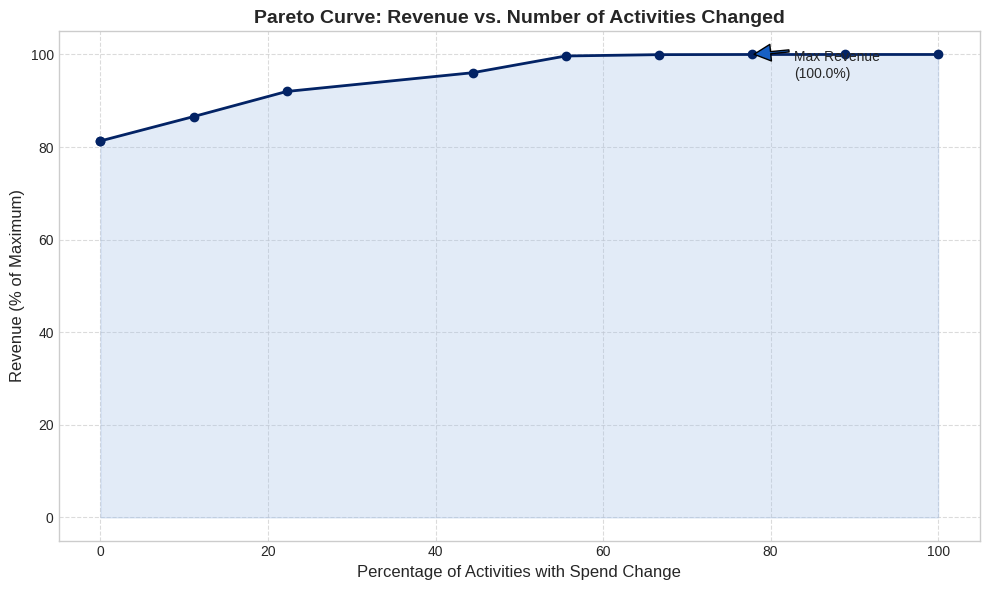

Processing date: 2024-03-02 00:00:00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 45 columns and 135 nonzeros
Model fingerprint: 0xddf1db28
Model has 9 quadratic objective terms
Variable types: 18 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+01]
  Objective range  [5e-05, 3e+00]
  QObjective range [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 9e+01]
Found heuristic solution: objective 9.4593117
Presolve removed 19 rows and 18 columns
Presolve time: 0.00s
Presolved: 38 rows, 38 columns, 109 nonzeros
Presolved model has 9 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 20 continuous, 18 integer (18 binary)

Root relaxation: objective 1.217875e+01, 16 iterations, 0.00 seconds (0.00

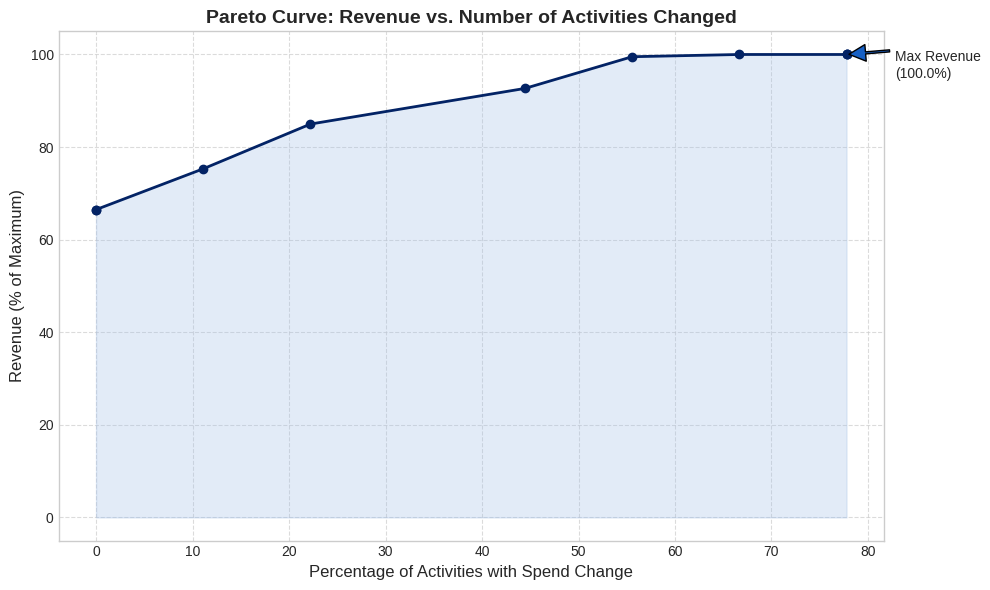

Processing date: 2024-04-02 00:00:00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 45 columns and 127 nonzeros
Model fingerprint: 0x20450594
Model has 9 quadratic objective terms
Variable types: 18 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [5e-06, 4e+01]
  Objective range  [4e-05, 4e+00]
  QObjective range [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-05, 7e+01]
Found heuristic solution: objective 2.3053491
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolved: 30 rows, 30 columns, 85 nonzeros
Presolved model has 7 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 16 continuous, 14 integer (14 binary)

Root relaxation: objective 3.983187e+00, 11 iterations, 0.00 seconds (0.00 

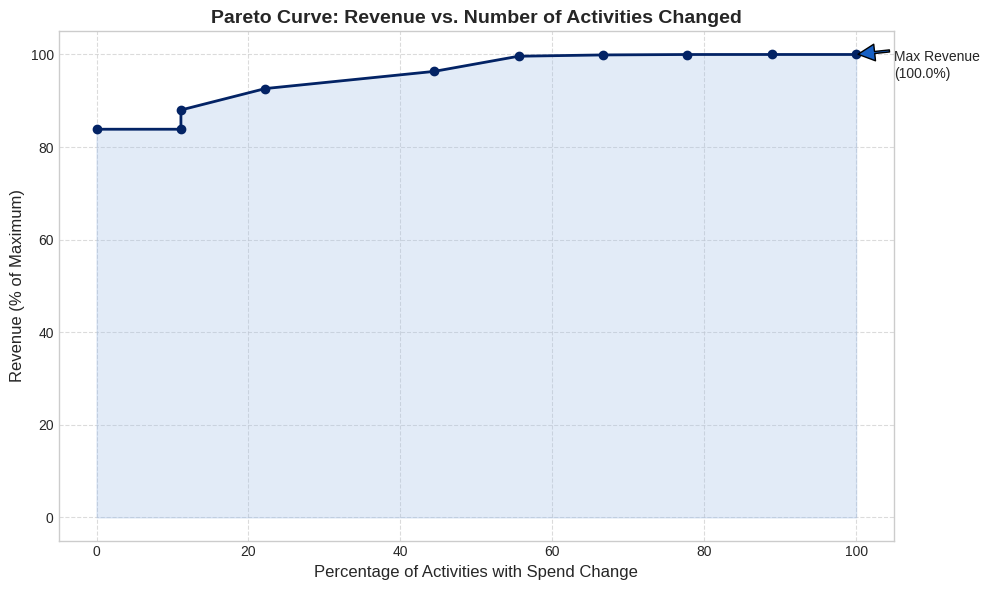

Processing date: 2024-05-02 00:00:00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 45 columns and 135 nonzeros
Model fingerprint: 0x4a1193a9
Model has 9 quadratic objective terms
Variable types: 18 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [6e-06, 4e+01]
  Objective range  [2e-04, 4e+00]
  QObjective range [3e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 8e+01]
Found heuristic solution: objective 11.8083519
Presolve removed 19 rows and 18 columns
Presolve time: 0.00s
Presolved: 36 rows, 38 columns, 105 nonzeros
Presolved model has 2 quadratic constraint(s)
Presolved model has 7 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 20 continuous, 18 integer (18 binary)

Root relaxation: objective 

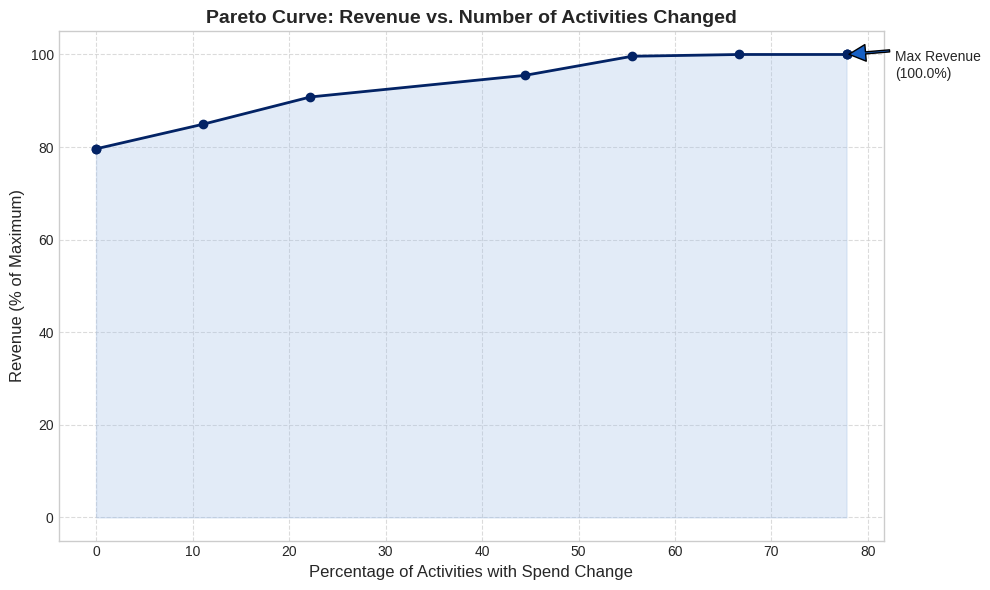

Processing date: 2024-06-02 00:00:00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 45 columns and 127 nonzeros
Model fingerprint: 0x1238ec1e
Model has 9 quadratic objective terms
Variable types: 18 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [5e-06, 4e+01]
  Objective range  [1e-04, 4e+00]
  QObjective range [3e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-05, 8e+01]
Found heuristic solution: objective 9.1001426
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolved: 30 rows, 30 columns, 85 nonzeros
Presolved model has 7 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 16 continuous, 14 integer (14 binary)

Root relaxation: objective 1.120090e+01, 10 iterations, 0.00 seconds (0.00 

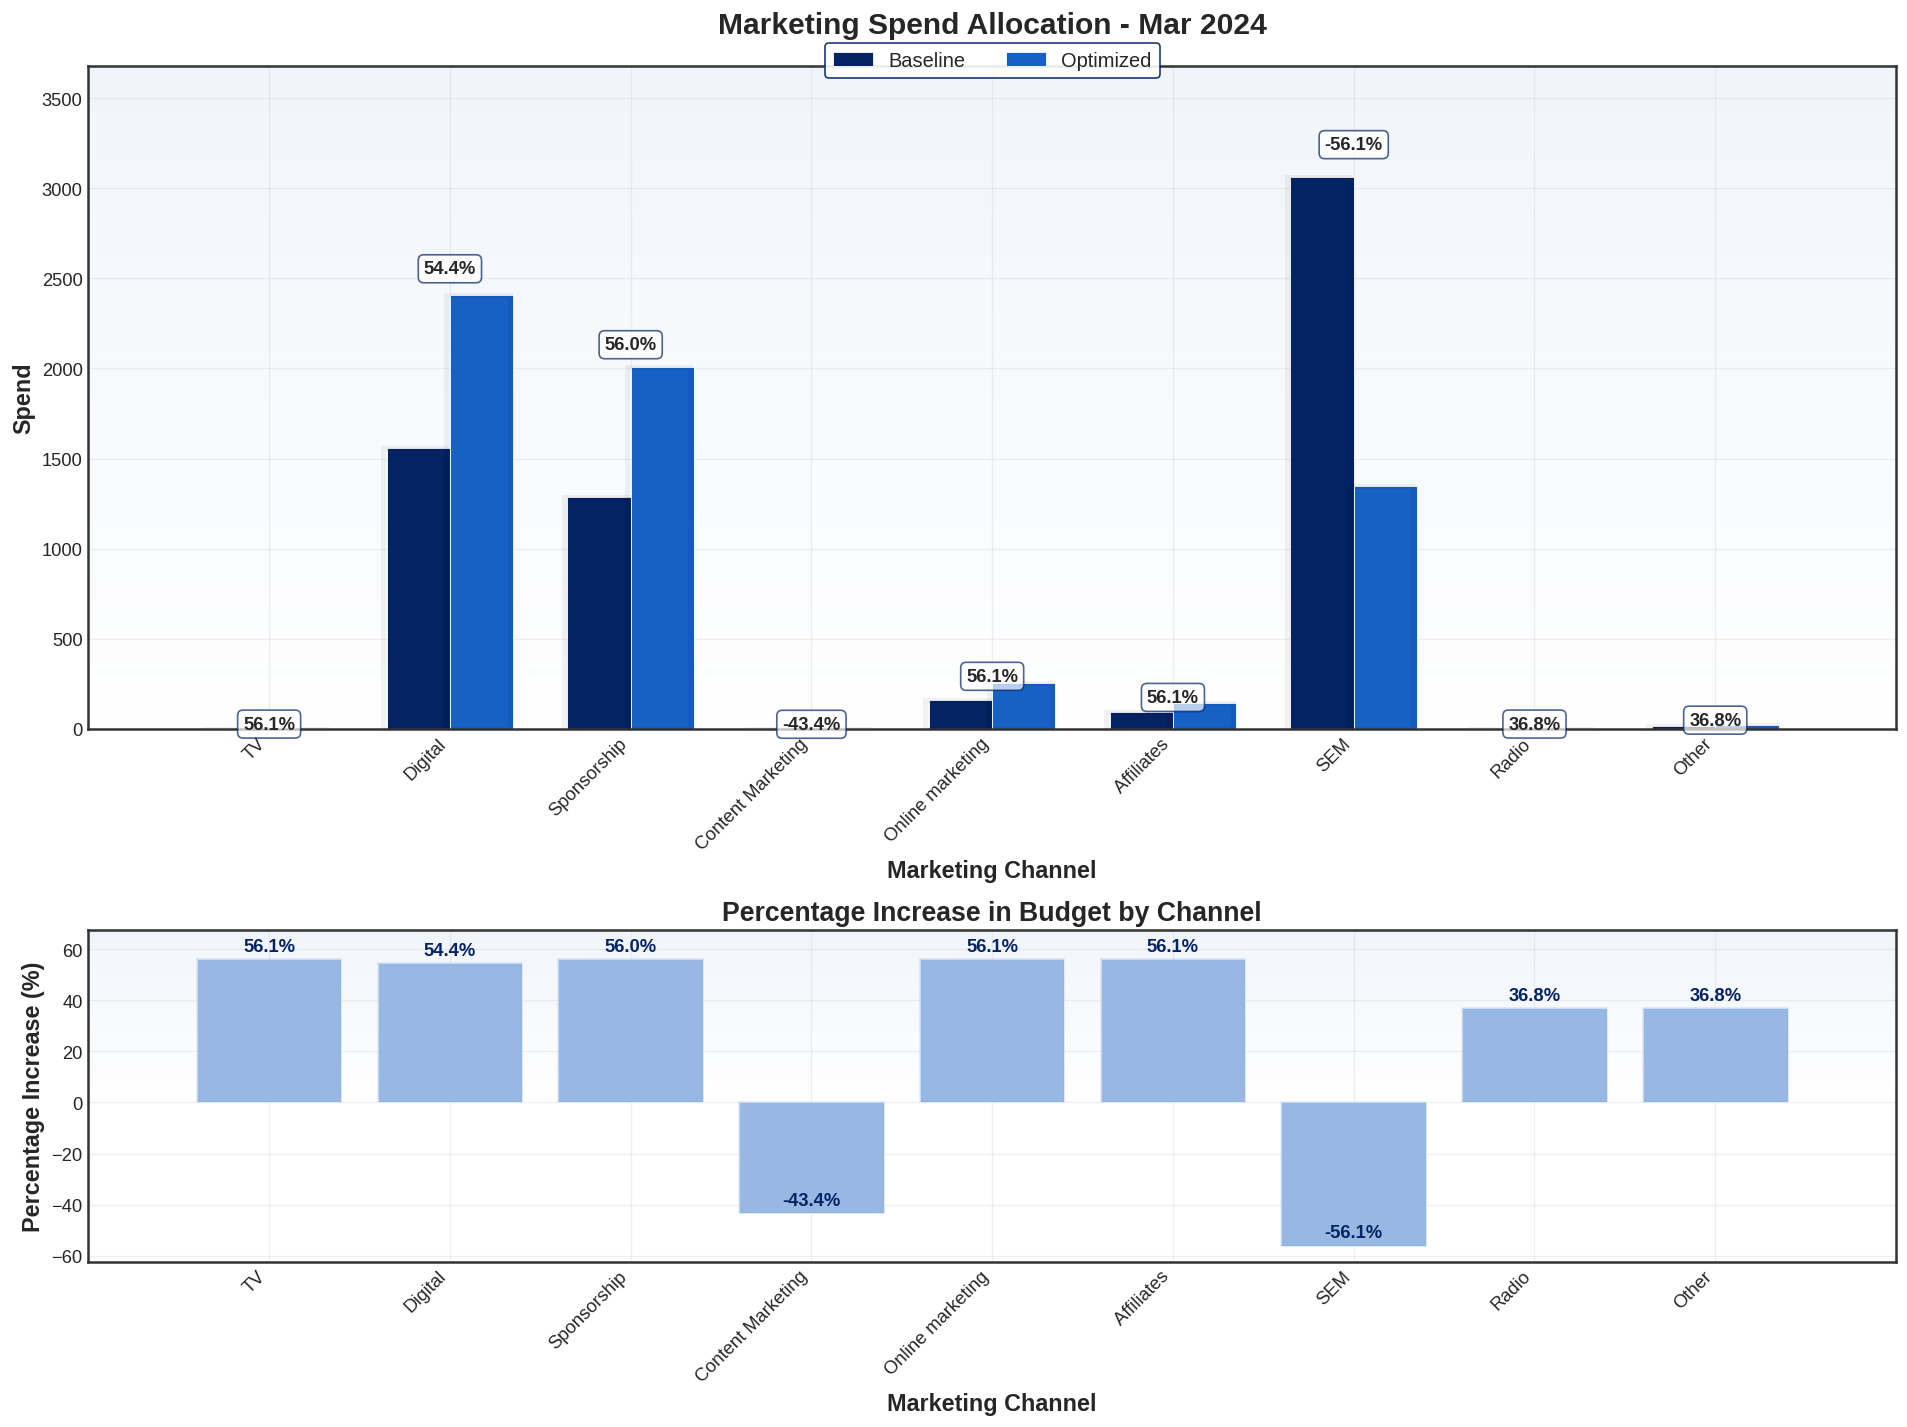

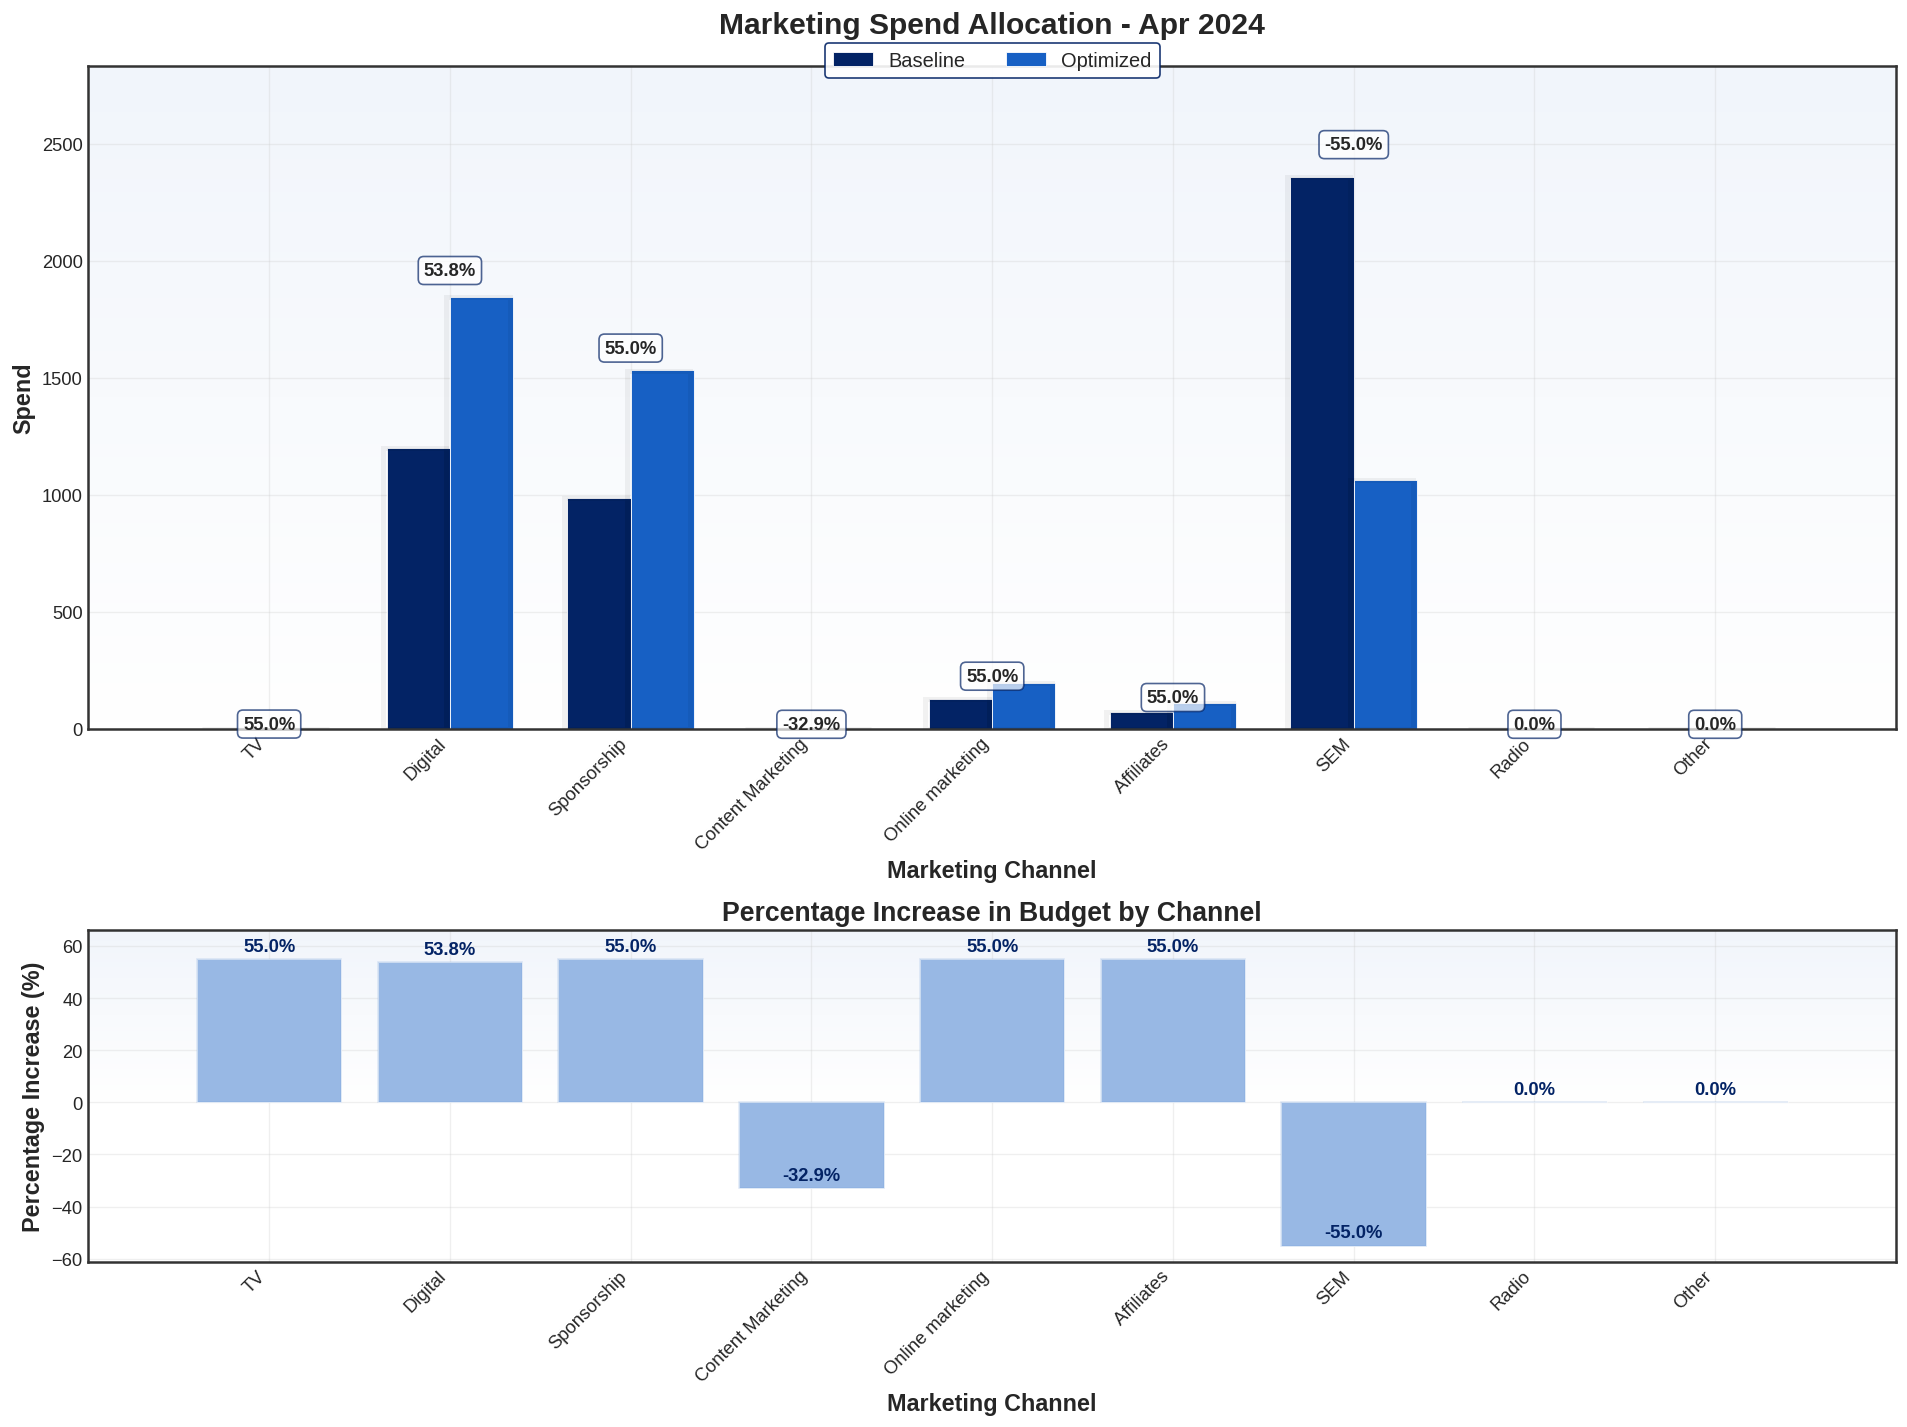

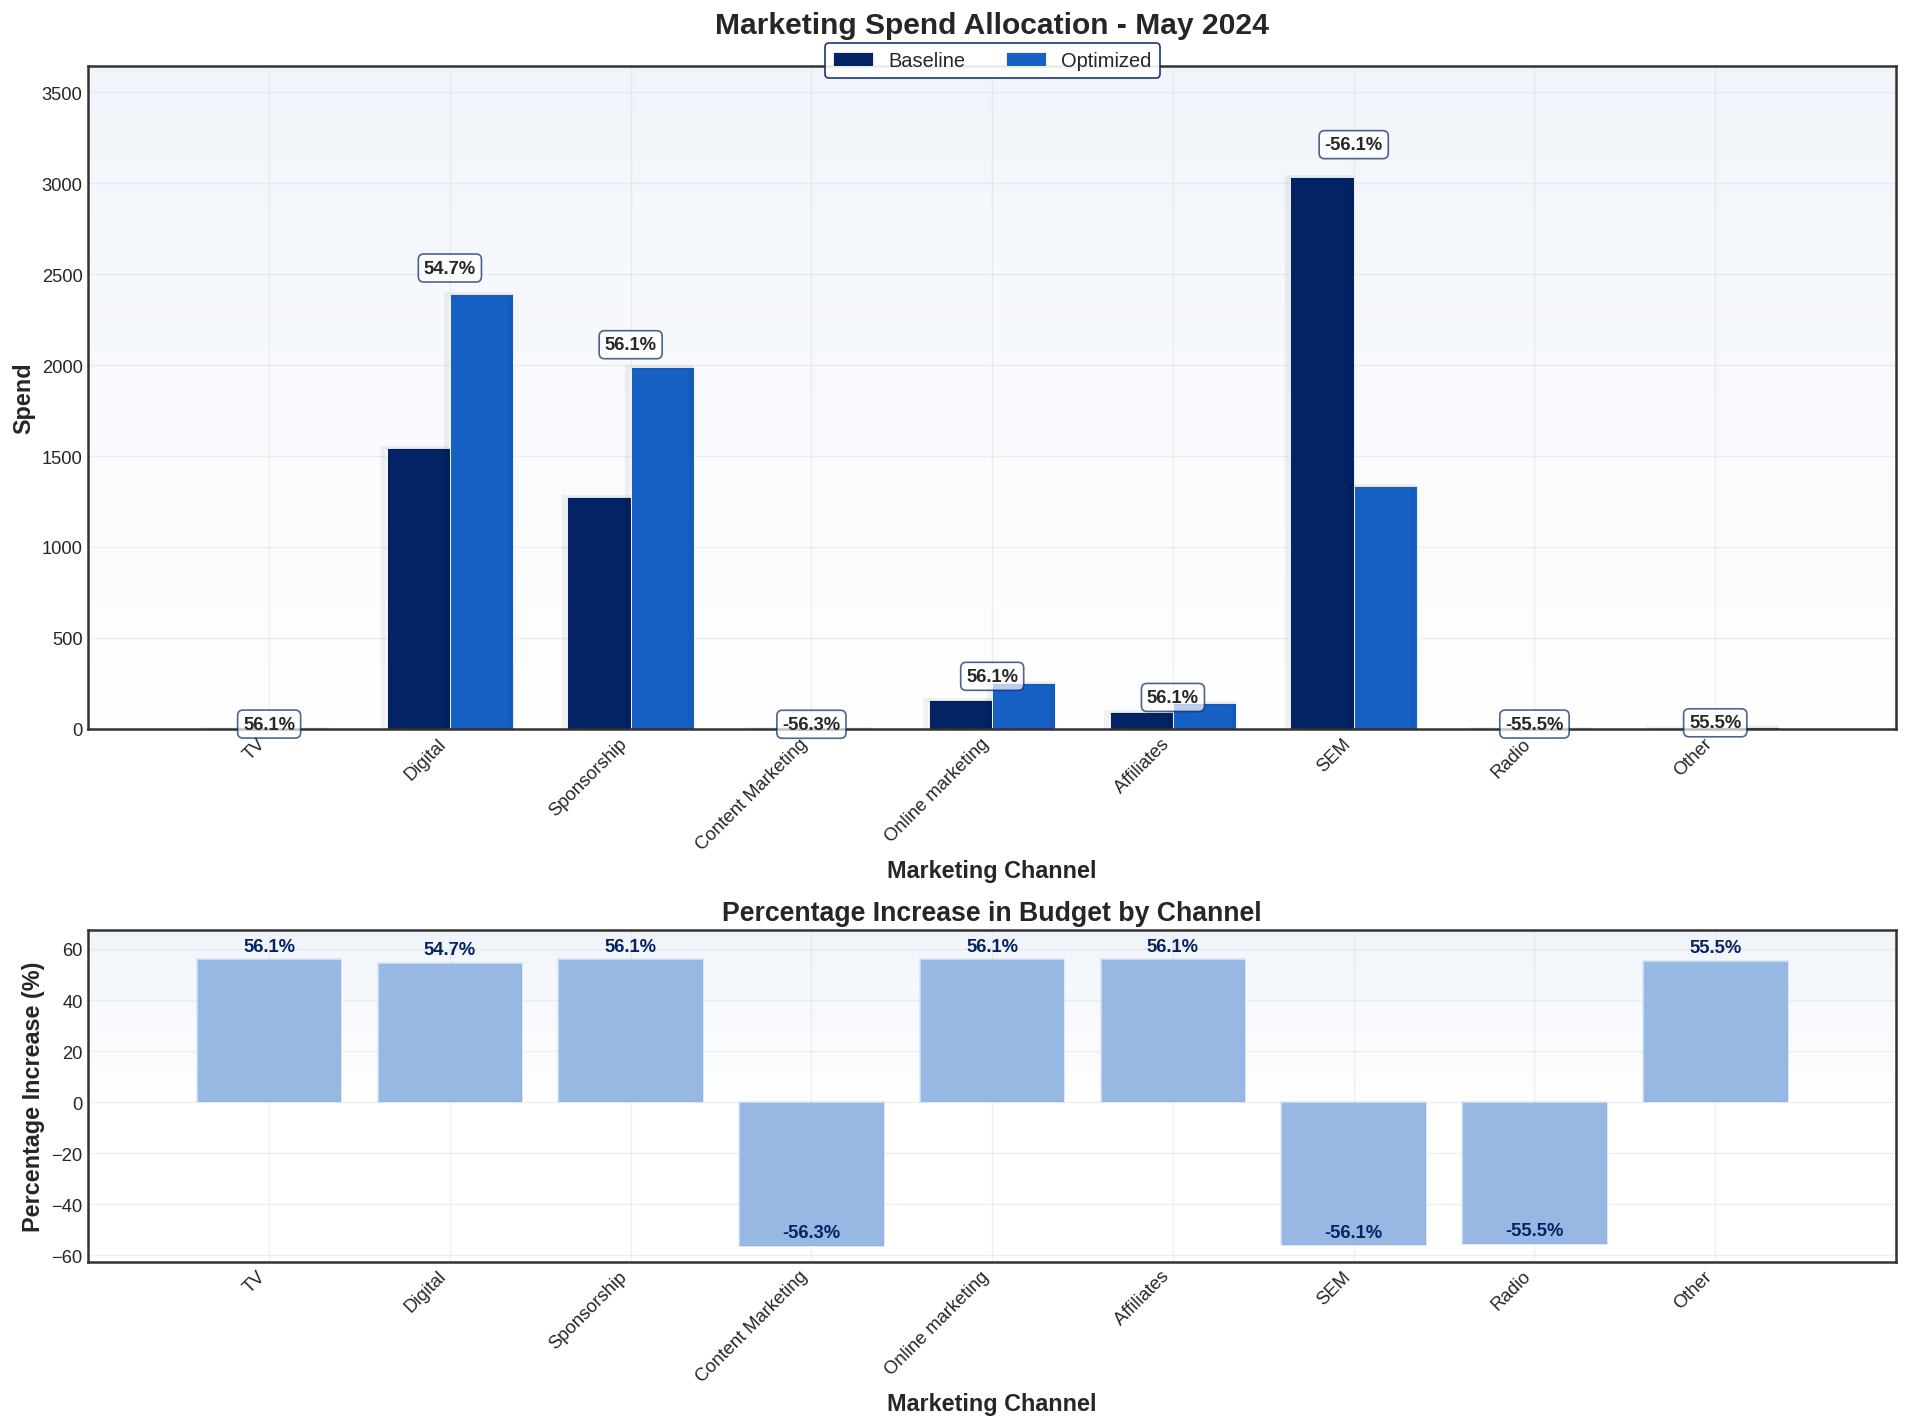

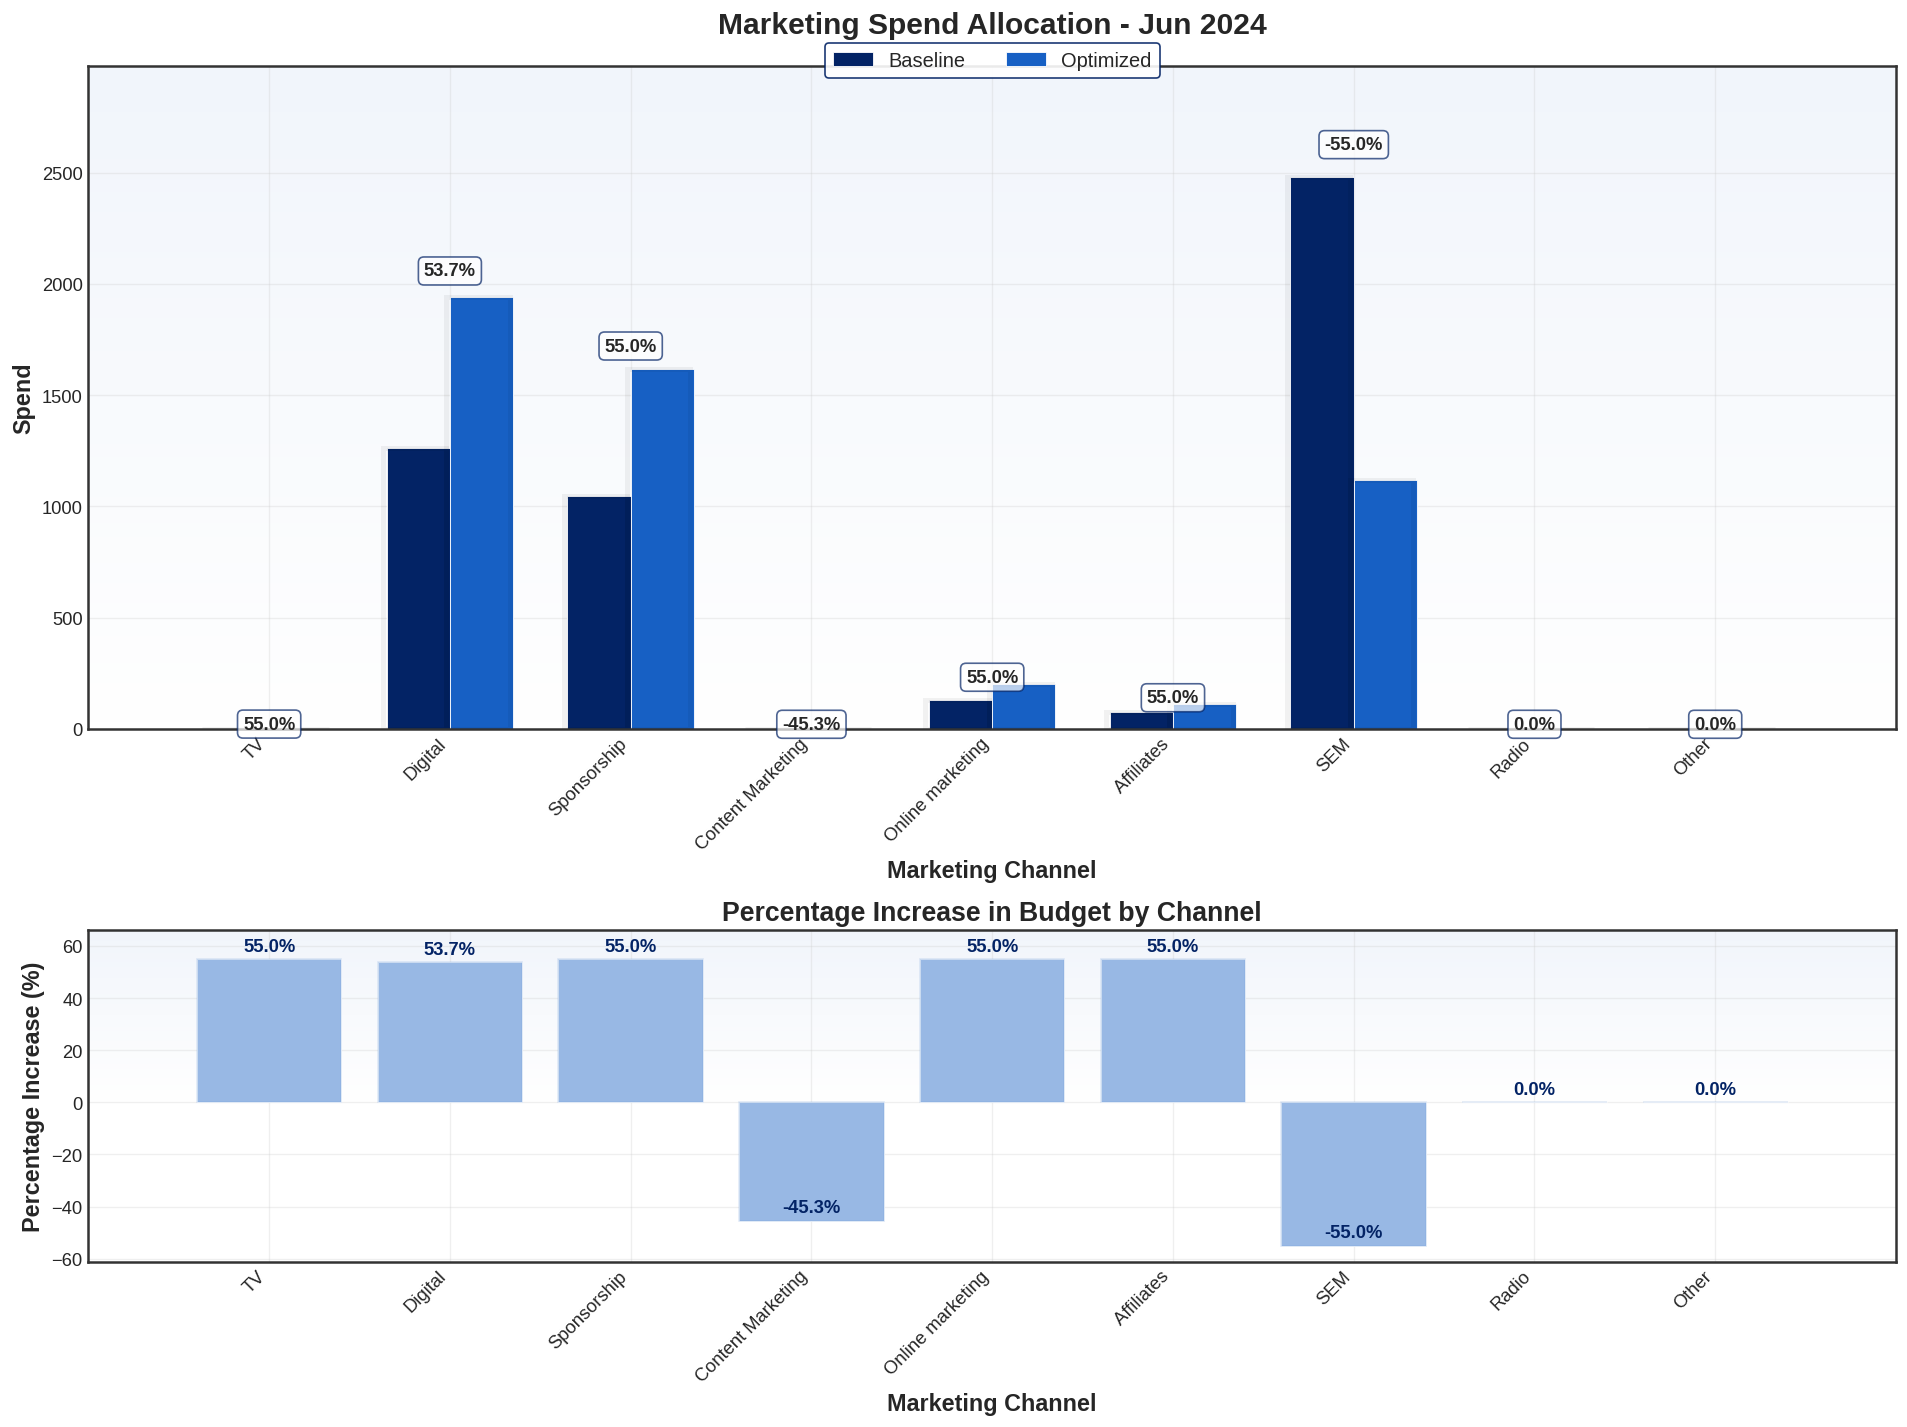

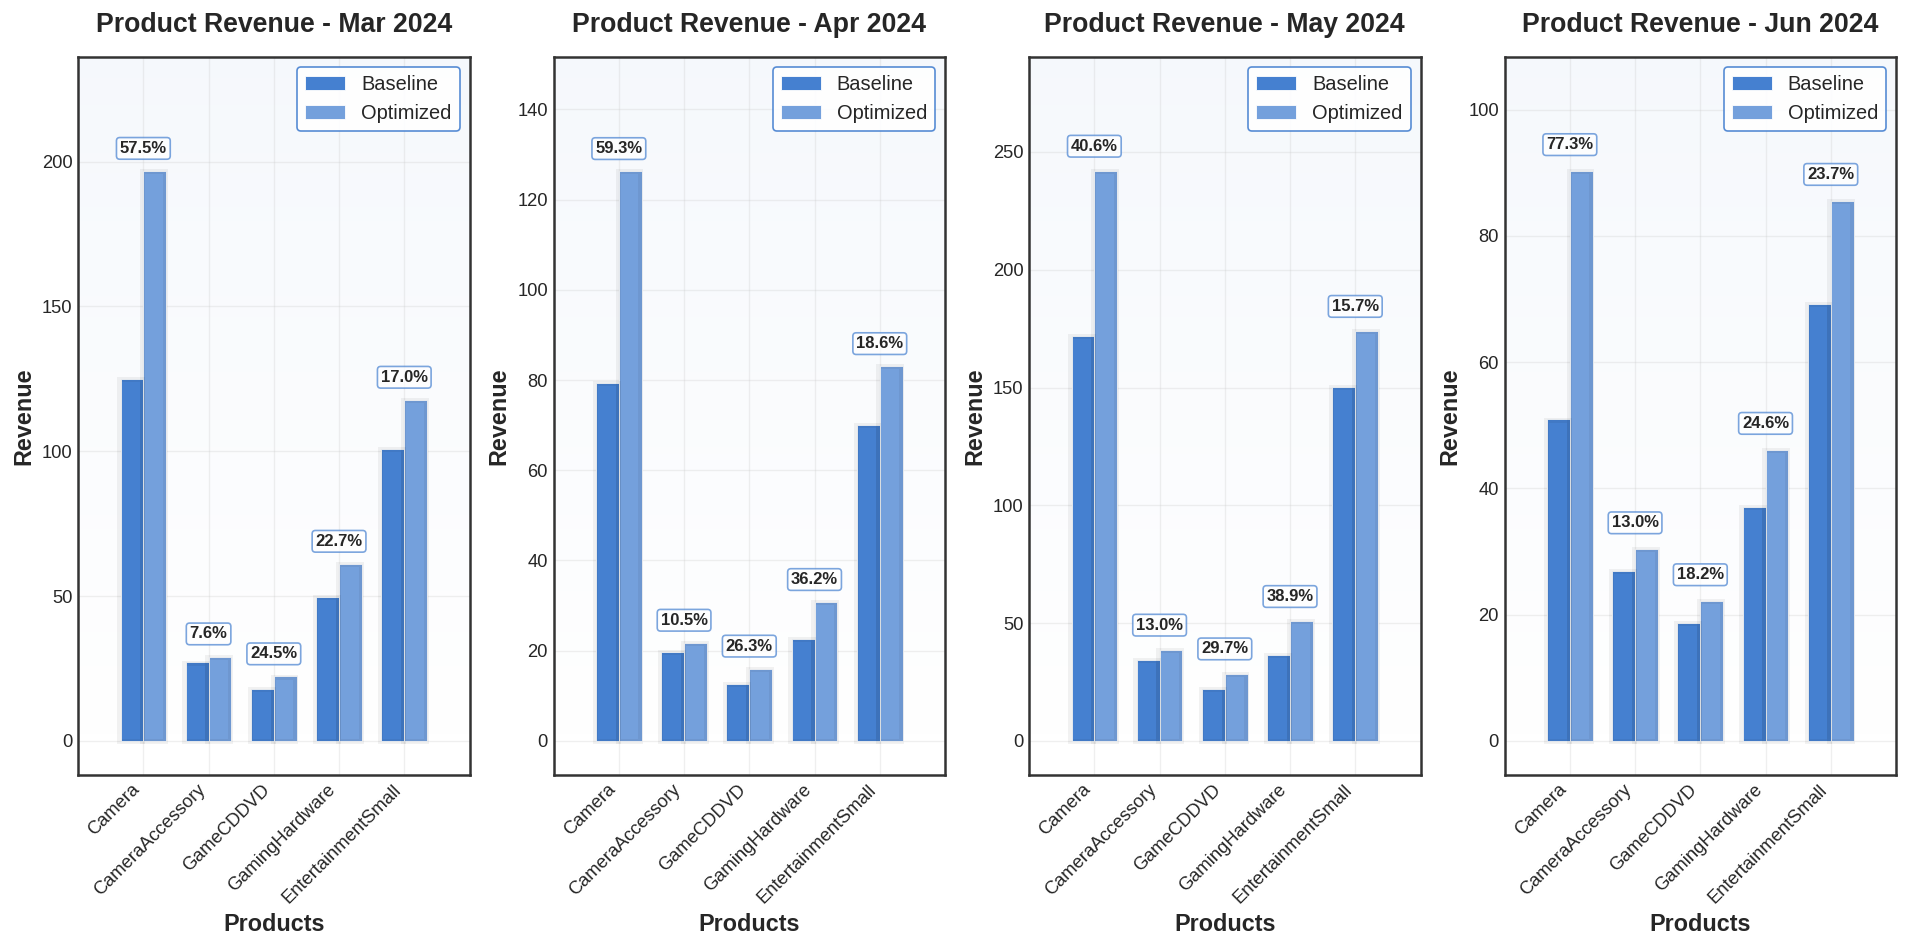

<ipython-input-49-f54faaf1de51>:399: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(product_list, rotation=45, ha='right')
<ipython-input-49-f54faaf1de51>:399: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(product_list, rotation=45, ha='right')
<ipython-input-49-f54faaf1de51>:399: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(product_list, rotation=45, ha='right')
<ipython-input-49-f54faaf1de51>:399: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(product_list, rotation=45, ha='right')


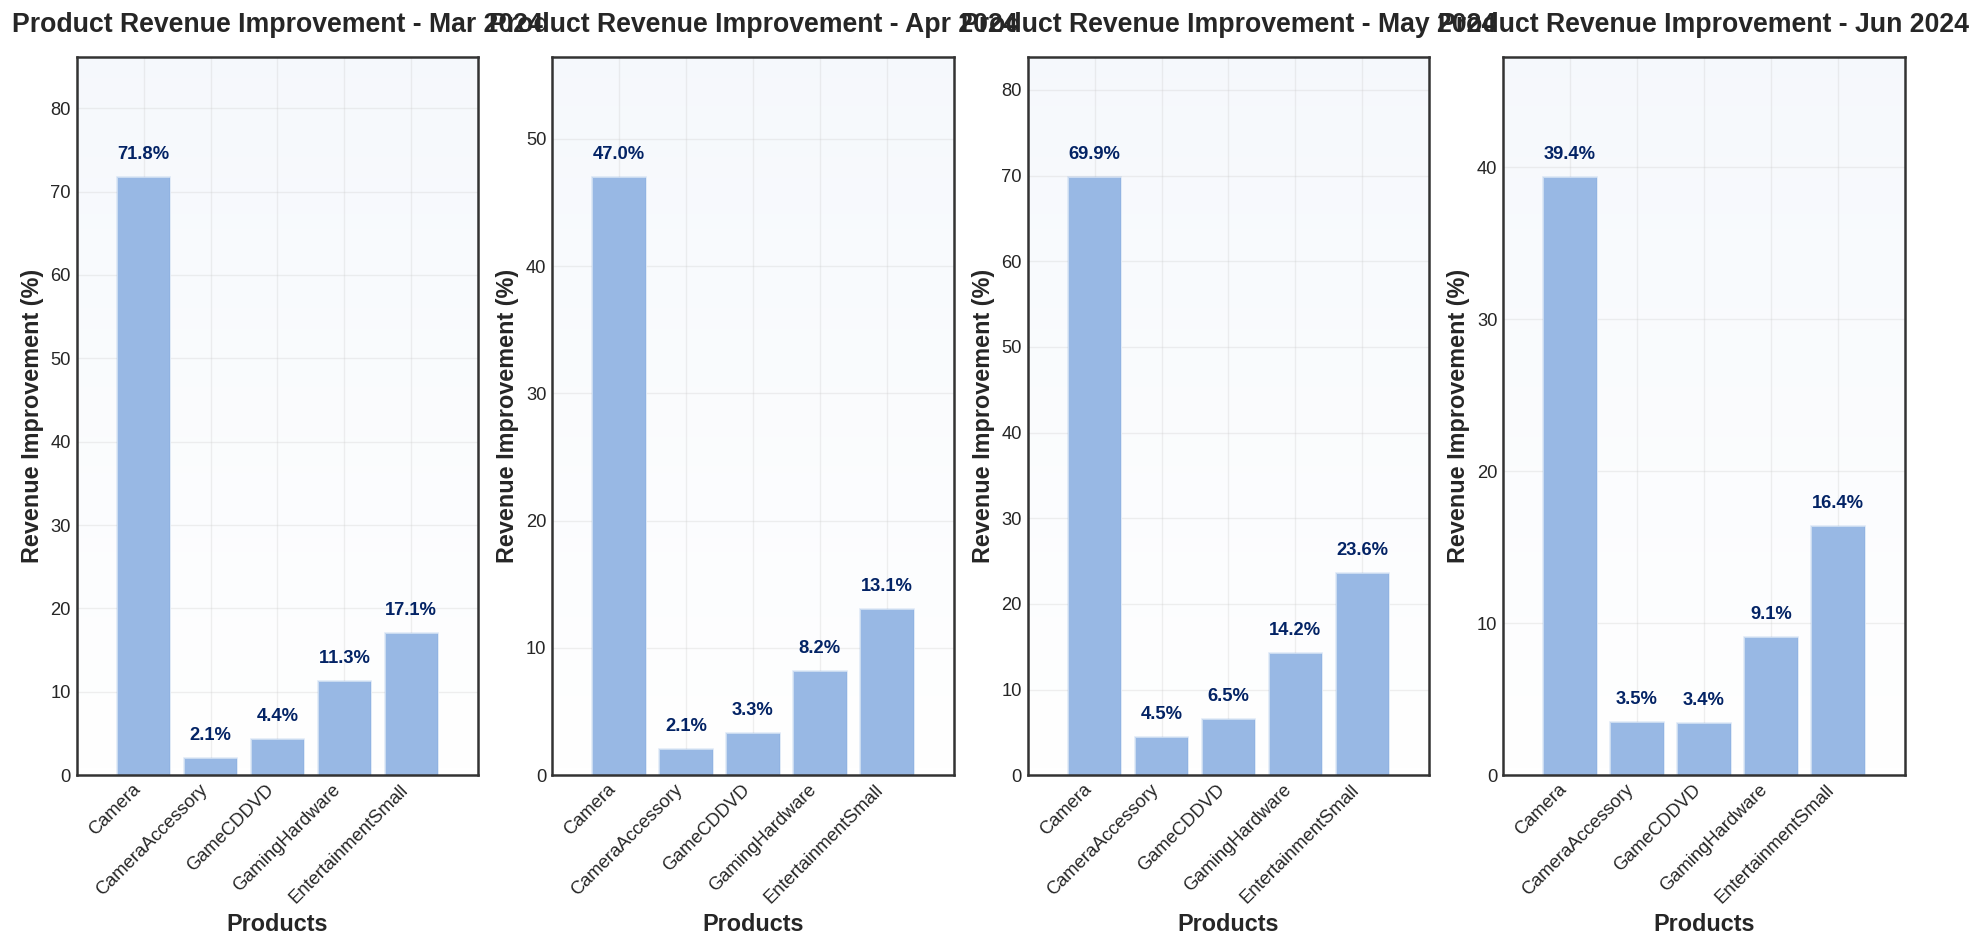

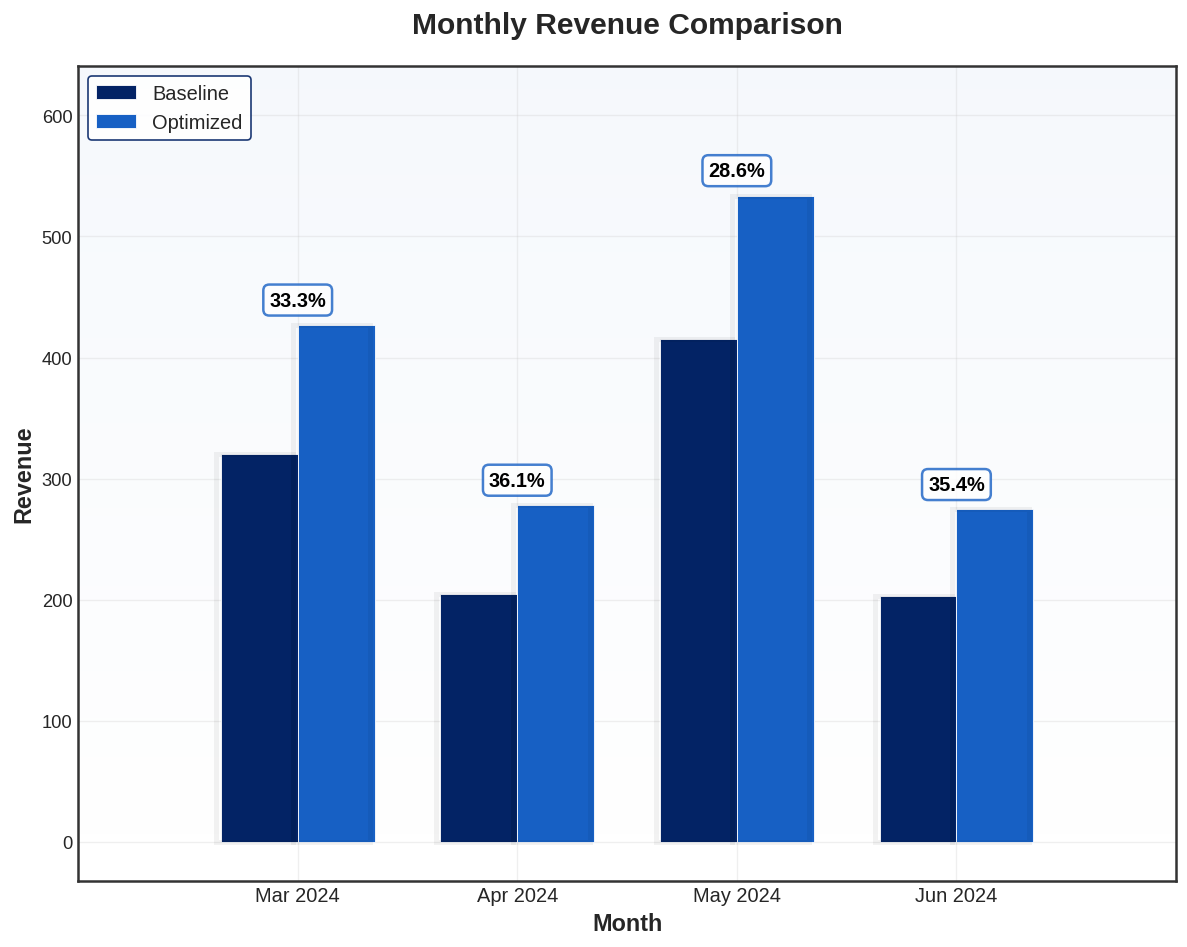


Percentage Increase in Budget by Channel:
       Month            Channel  Baseline Spend  Optimized Spend  \
0   Mar 2024                 TV        0.670958         1.047314   
1   Mar 2024            Digital     1559.531243      2407.976768   
2   Mar 2024        Sponsorship     1285.837797      2006.528668   
3   Mar 2024  Content Marketing        0.002288         0.001296   
4   Mar 2024   Online marketing      162.425255       253.555183   
5   Mar 2024         Affiliates       90.933831       141.928525   
6   Mar 2024                SEM     3064.204422      1346.400018   
7   Mar 2024              Radio        0.868227         1.187348   
8   Mar 2024              Other       15.913055        21.761958   
9   Apr 2024                 TV        0.587406         0.910480   
10  Apr 2024            Digital     1200.589297      1846.219206   
11  Apr 2024        Sponsorship      987.522900      1530.554141   
12  Apr 2024  Content Marketing        0.001938         0.001300   
13  A

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
result = run_train_test_optimization(df)

<h1><b>Marketing Channel importance for each Product

To determine which marketing channels should be leveraged for each product category, we trained separate **XGBoost regression models** using historical sales data, where marketing channels served as input features and **Gross Merchandise Value (GMV)** as the target variable. We extracted **feature importance scores** to identify the top three most influential marketing channels for each product. These channels are the most impactful in driving sales and should be prioritized for future marketing investments. The rationale behind this approach is that **higher feature importance scores indicate stronger predictive power**, meaning these channels have historically contributed the most to sales performance. By leveraging these insights, businesses can optimize marketing spend by focusing on the most effective channels, thereby improving return on investment (ROI) and enhancing category-specific sales strategies.

<Figure size 1200x600 with 0 Axes>

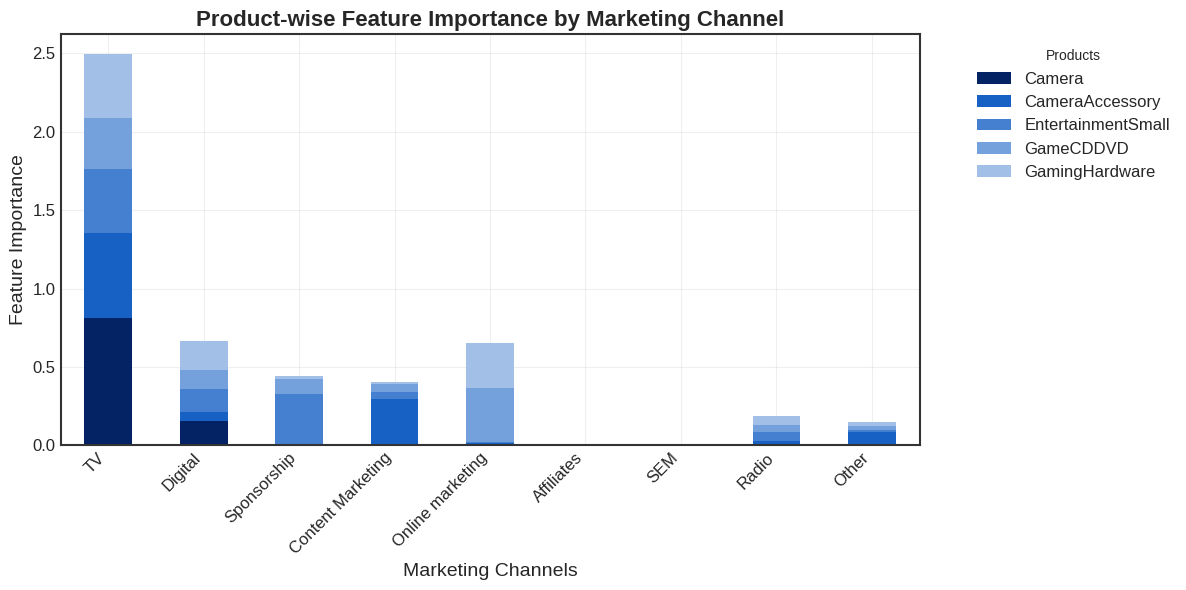

In [ ]:
date_col = 'date'
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col)

df.columns = df.columns.str.strip()

product_categories = ['Camera', 'CameraAccessory', 'EntertainmentSmall',
                      'GameCDDVD', 'GamingHardware']
marketing_channels = ['TV', 'Digital', 'Sponsorship', 'Content Marketing',
                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other']


split_date = '2024-06-30'
train_df = df[df[date_col] < split_date]
test_df = df[df[date_col] >= split_date]

marketing_features = marketing_channels

feature_importance_df = pd.DataFrame(index=product_categories, columns=marketing_features)

for product in product_categories:
    gmv_col = f'{product}_gmv'

    feature_cols = [col for col in marketing_features if col in df.columns]

    X_train, X_test = train_df[feature_cols], test_df[feature_cols]
    y_train, y_test = train_df[gmv_col], test_df[gmv_col]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
    model.fit(X_train, y_train)

    importance_values = model.feature_importances_
    importance_series = pd.Series(importance_values, index=feature_cols)

    feature_importance_df.loc[product] = importance_series.reindex(marketing_features).fillna(0)

feature_importance_df = feature_importance_df.astype(float)


colors = ['#032365', '#1760C4', '#4580d0', '#74a0dc', '#a2bfe7', '#d1dff3']

plt.figure(figsize=(12, 6))  # Set figure size

feature_importance_df.T.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors[:len(marketing_channels)])

plt.title('Product-wise Feature Importance by Marketing Channel', fontsize=16, weight='bold')
plt.ylabel('Feature Importance', fontsize=14)
plt.xlabel('Marketing Channels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Products', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()

plt.show()
